# Supervised Clustering with Shap Values

--------------------------------------

### Importing libraries, preparing data and creating functions

In [416]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib import style
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score


import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



shap.initjs()

In [678]:
#time function to track running time
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now()- start_time).total_seconds(), 3600)
        tmin, tsec= divmod(temp_sec, 60)
        print("\n Time taken: %i hours %i minutes and %i seconds." % (thour, tmin, round(tsec,2)))
        
#function to calculate features to remove based on correlation
def correlation(dataset, threshold):
    col_corr=set()
    corr_matrix=dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname=corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

#Calculate accuracy and fale positive rate of binary classification
def accuracy0Malware(dataset):
    count= 0
    for i in range(len(dataset)):
        if (dataset["Cluster"][i]== 0 and dataset["Class"][i]== "Malware") or (dataset["Cluster"][i]== 1 and dataset["Class"][i]== "Benign"):
            count += 1
        
    return print("Accuracy:", count/len(dataset)*100, "% \n False Positive rate:", len(dataset[dataset.Cluster==1][SHAPDF.Class== "Malware"])/(len(dataset[dataset.Cluster==1][dataset.Class== "Malware"])+len(dataset[dataset.Cluster==0][dataset.Class=="Malware"])) * 100, "%") 

def accuracy0Benign(dataset):
    count= 0
    for i in range(len(dataset)):
        if (dataset["Cluster"][i]== 1 and dataset["Class"][i]== "Malware") or (dataset["Cluster"][i]== 0 and dataset["Class"][i]== "Benign"):
            count += 1
        
    return print("Accuracy:", count/len(dataset)*100, "% \n False Positive rate:", len(dataset[dataset.Cluster==0][dataset.Class== "Malware"])/(len(dataset[dataset.Cluster==0][dataset.Class== "Malware"])+len(dataset[dataset.Cluster==1][dataset.Class=="Malware"])) * 100, "%") 


In [418]:
#Importing the data 
dataset= pd.read_csv("C:/Users/rodri/OneDrive/Desktop/tese/Data/Obfuscated-MalMem2022.csv")

#Separating the Category column into category and family
dataset[["Category", "Family1", "idk"]]=dataset["Category"].str.split("-", n=2, expand= True)
dataset.drop("idk",axis=1, inplace= True)


#Arranging the family column
classes=[]
for i in range(len(dataset)):
    if dataset["Class"][i]== "Benign":
        classes.append("Benign")
    else:
        classes.append(dataset["Family1"][i])
dataset["Family"]= classes

dataset.drop("Family1", axis=1,inplace= True)

#Dropping meaningless features
dataset.drop(["pslist.nprocs64bit","handles.nport","svcscan.interactive_process_services"], axis= 1, inplace= True)

#creating lists with all the features
Features=['Category', 'pslist.nproc', 'pslist.nppid', 'pslist.avg_threads',
       'pslist.avg_handlers', 'dlllist.ndlls',
       'dlllist.avg_dlls_per_proc', 'handles.nhandles',
       'handles.avg_handles_per_proc','handles.nfile',
       'handles.nevent', 'handles.ndesktop', 'handles.nkey', 'handles.nthread',
       'handles.ndirectory', 'handles.nsemaphore', 'handles.ntimer',
       'handles.nsection', 'handles.nmutant', 'ldrmodules.not_in_load',
       'ldrmodules.not_in_init', 'ldrmodules.not_in_mem',
       'ldrmodules.not_in_load_avg', 'ldrmodules.not_in_init_avg',
       'ldrmodules.not_in_mem_avg', 'malfind.ninjections',
       'malfind.commitCharge', 'malfind.protection',
       'malfind.uniqueInjections', 'psxview.not_in_pslist',
       'psxview.not_in_eprocess_pool', 'psxview.not_in_ethread_pool',
       'psxview.not_in_pspcid_list', 'psxview.not_in_csrss_handles',
       'psxview.not_in_session', 'psxview.not_in_deskthrd',
       'psxview.not_in_pslist_false_avg',
       'psxview.not_in_eprocess_pool_false_avg',
       'psxview.not_in_ethread_pool_false_avg',
       'psxview.not_in_pspcid_list_false_avg',
       'psxview.not_in_csrss_handles_false_avg',
       'psxview.not_in_session_false_avg', 'psxview.not_in_deskthrd_false_avg',
       'modules.nmodules', 'svcscan.nservices', 'svcscan.kernel_drivers',
       'svcscan.fs_drivers', 'svcscan.process_services',
       'svcscan.shared_process_services',
       'svcscan.nactive',
       'callbacks.ncallbacks', 'callbacks.nanonymous', 'callbacks.ngeneric',
       'Class', 'Family']

Features1=['pslist.nproc', 'pslist.nppid', 'pslist.avg_threads',
       'pslist.avg_handlers', 'dlllist.ndlls',
       'dlllist.avg_dlls_per_proc', 'handles.nhandles',
       'handles.avg_handles_per_proc','handles.nfile',
       'handles.nevent', 'handles.ndesktop', 'handles.nkey', 'handles.nthread',
       'handles.ndirectory', 'handles.nsemaphore', 'handles.ntimer',
       'handles.nsection', 'handles.nmutant', 'ldrmodules.not_in_load',
       'ldrmodules.not_in_init', 'ldrmodules.not_in_mem',
       'ldrmodules.not_in_load_avg', 'ldrmodules.not_in_init_avg',
       'ldrmodules.not_in_mem_avg', 'malfind.ninjections',
       'malfind.commitCharge', 'malfind.protection',
       'malfind.uniqueInjections', 'psxview.not_in_pslist',
       'psxview.not_in_eprocess_pool', 'psxview.not_in_ethread_pool',
       'psxview.not_in_pspcid_list', 'psxview.not_in_csrss_handles',
       'psxview.not_in_session', 'psxview.not_in_deskthrd',
       'psxview.not_in_pslist_false_avg',
       'psxview.not_in_eprocess_pool_false_avg',
       'psxview.not_in_ethread_pool_false_avg',
       'psxview.not_in_pspcid_list_false_avg',
       'psxview.not_in_csrss_handles_false_avg',
       'psxview.not_in_session_false_avg', 'psxview.not_in_deskthrd_false_avg',
       'modules.nmodules', 'svcscan.nservices', 'svcscan.kernel_drivers',
       'svcscan.fs_drivers', 'svcscan.process_services',
       'svcscan.shared_process_services',
       'svcscan.nactive',
       'callbacks.ncallbacks', 'callbacks.nanonymous', 'callbacks.ngeneric']



In [419]:
pd.set_option('display.max_columns', None)
dataset.describe()

pslist.nproc  pslist.nppid  pslist.avg_threads  pslist.avg_handlers  \
count  58596.000000  58596.000000        58596.000000         58596.000000   
mean      41.394771     14.713837           11.341655           247.509819   
std        5.777249      2.656748            1.588231           111.857790   
min       21.000000      8.000000            1.650000            34.962500   
25%       40.000000     12.000000            9.972973           208.725000   
50%       41.000000     15.000000           11.000000           243.963710   
75%       43.000000     16.000000           12.861955           289.974322   
max      240.000000     72.000000           16.818182         24845.951220   

       dlllist.ndlls  dlllist.avg_dlls_per_proc  handles.nhandles  \
count   58596.000000               58596.000000      5.859600e+04   
mean     1810.805447                  43.707806      1.025858e+04   
std       329.782639                   5.742023      4.866864e+03   
min       670.000000                   7.333333      3.514000e+03   
25%      1556.000000                  38.833333      8.393000e+03   
50%      1735.000000                  42.781524      9.287500e+03   
75%      2087.000000                  49.605280      1.219300e+04   
max      3443.000000                  53.170732      1.047310e+06   

       handles.avg_handles_per_proc  handles.nfile  handles.nevent  \
count                  58596.000000   58596.000000    58596.000000   
mean                     249.560958     899.119513     3572.409960   
std                      145.999866    3432.351200      805.460522   
min                       71.139241     266.000000      966.000000   
25%                      209.648228     646.000000     2923.000000   
50%                      247.208951     839.000000     3151.000000   
75%                      291.355050    1080.000000     4321.000000   
max                    33784.193550  807008.000000     7892.000000   

       handles.ndesktop  handles.nkey  handles.nthread  handles.ndirectory  \
count      58596.000000  58596.000000     58596.000000        58596.000000   
mean          44.529166    774.280668       928.510086          102.398338   
std            5.161254    150.407075       237.817566            9.782695   
min           22.000000    284.000000       388.000000           57.000000   
25%           43.000000    675.000000       708.000000           99.000000   
50%           45.000000    753.000000       848.000000          103.000000   
75%           46.000000    859.000000      1169.000000          107.000000   
max          159.000000   2668.000000      5637.000000          498.000000   

       handles.nsemaphore  handles.ntimer  handles.nsection  handles.nmutant  \
count        58596.000000    58596.000000      58596.000000     58596.000000   
mean           683.339324      130.327855        290.127466       312.588829   
std             94.531078       14.965266        144.278832        73.173189   
min            296.000000       69.000000         50.000000       118.000000   
25%            614.000000      120.000000        177.000000       258.000000   
50%            684.000000      131.000000        224.000000       289.000000   
75%            750.000000      142.000000        415.000000       366.000000   
max           4268.000000      382.000000      14687.000000       583.000000   

       ldrmodules.not_in_load  ldrmodules.not_in_init  ldrmodules.not_in_mem  \
count            58596.000000            58596.000000           58596.000000   
mean                60.830347               99.946413              60.832599   
std                 18.761422               21.438482              18.759947   
min                  6.000000               16.000000               6.000000   
25%                 46.000000               85.000000              46.000000   
50%                 57.000000               97.000000              57.000000   
75%                 74.000000              115.000000              

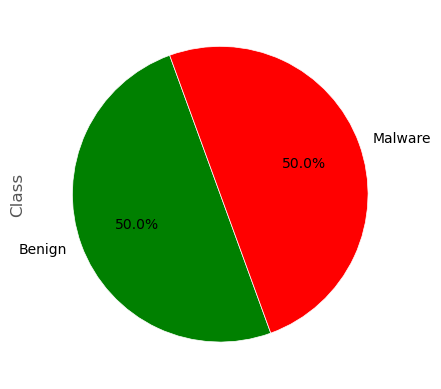

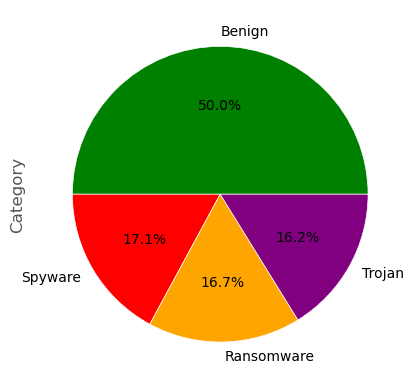

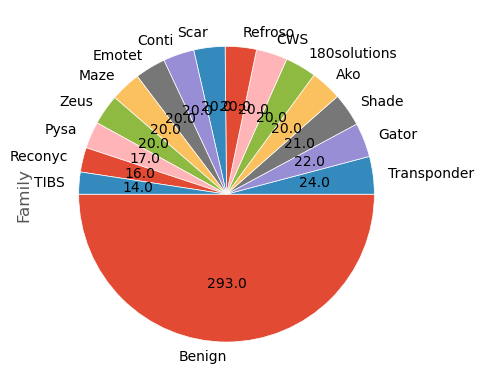

In [420]:
#Producing pie charts to vizualise the data

sizes=[]
for i in range(len(dataset.Family.value_counts())):
     sizes.append(dataset.Family.value_counts()[i])
        
sizes=np.array(sizes)
        
def absolute_value(val):
    a  = np.round(val/10000.*sizes.sum(), decimals=0)
    return a

dataset.Class.value_counts().plot.pie(wedgeprops={'edgecolor': 'white'}, autopct='%1.1f%%',startangle=110, colors=["Green", "Red"])
plt.show()

dataset.Category.value_counts().plot.pie(wedgeprops={'edgecolor': 'white'}, autopct='%1.1f%%', colors=["Green", "Red", "Orange", "Purple"])
plt.show()

dataset.Family.value_counts().plot.pie(wedgeprops={'edgecolor': 'white'}, autopct=absolute_value,  startangle=180)
plt.show()



In [421]:
dataset.Class.value_counts()

Benign     29298
Malware    29298
Name: Class, dtype: int64

In [422]:
dataset.shape[0]

58596

In [423]:
len(dataset.Family.value_counts())

16

In [424]:
len(dataset)

58596

## Unsupervised Clustering

### Removing correlated features

In [425]:
datasetScaled= dataset.copy()
datasetScaled.drop(["Category","Class", "Family"], axis=1, inplace= True)

In [426]:
corr_features=correlation(datasetScaled, 0.7)
datasetScaled.drop(corr_features, axis=1, inplace= True)
FeaturesCorr=datasetScaled.columns
FeaturesCorr

Index(['pslist.nproc', 'pslist.nppid', 'pslist.avg_handlers', 'dlllist.ndlls',
       'ldrmodules.not_in_load_avg', 'malfind.ninjections',
       'malfind.commitCharge', 'psxview.not_in_pslist',
       'psxview.not_in_eprocess_pool', 'modules.nmodules', 'svcscan.nservices',
       'callbacks.ncallbacks', 'callbacks.nanonymous', 'callbacks.ngeneric'],
      dtype='object')

In [427]:
datasetScaled

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0                45            17           202.844444           1694   
1                47            19           242.234043           2074   
2                40            14           288.225000           1932   
3                32            13           264.281250           1445   
4                42            16           281.333333           2067   
...             ...           ...                  ...            ...   
58591            37            15           215.486487           1453   
58592            37            14           190.216216           1347   
58593            38            15           210.026316           1448   
58594            37            15           215.513513           1452   
58595            38            15           213.026316           1487   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                        0.030372                    5                    21   
1                        0.036167                   12                    77   
2                        0.026114                    5                     6   
3                        0.021483                    2                     2   
4                        0.047820                   12                    77   
...                           ...                  ...                   ...   
58591                    0.029292                    3                     3   
58592                    0.030958                    3                     3   
58593                    0.029292                    3                     3   
58594                    0.029392                    3                     3   
58595                    0.029255                    3                     3   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                          2                             0               138   
1                          0                             0               138   
2                          0                             0               137   
3                          0                             0               138   
4                          4                             0               138   
...                      ...                           ...               ...   
58591                      1                             0               138   
58592                      0                             0               138   
58593                      2                             0               138   
58594                      0                             0               138   
58595                      3                             0               138   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0                    389                    87                     0   
1                    392                    87                     0   
2                    395                    88                     0   
3                    395                    88                     0   
4                    392                    87                     0   
...                  ...                   ...                   ...   
58591                389                    86                     0   
58592                389                    88                     0   
58593                389                    88                     0   
58594                389                    87                     0   
58595                389                    86                     0   

       callbacks.ngeneric  
0                       8  
1                       8  
2                       8  
3                       8  
4                       8  
...                   ...  
58591                   8  
58592                   8  
58593                   8  
58594                   8  
58595                   8  

[58596

### Scaling the data

In [429]:
Scaler= StandardScaler()


datasetScaled= Scaler.fit_transform(datasetScaled)

datasetScaled= np.array(datasetScaled)

datasetScaled= pd.DataFrame(datasetScaled,columns=FeaturesCorr)

datasetScaled

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0          0.624044      0.860519            -0.399308      -0.354192   
1          0.970233      1.613326            -0.047165       0.798092   
2         -0.241427     -0.268691             0.363994       0.367501   
3         -1.626181     -0.645094             0.149937      -1.109241   
4          0.104762      0.484116             0.302382       0.776865   
...             ...           ...                  ...            ...   
58591     -0.760710      0.107713            -0.286289      -1.084983   
58592     -0.760710     -0.268691            -0.512205      -1.406409   
58593     -0.587615      0.107713            -0.335102      -1.100144   
58594     -0.760710      0.107713            -0.286047      -1.088015   
58595     -0.587615      0.107713            -0.308282      -0.981884   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                       -0.301971            -0.130618             -0.156946   
1                        0.323590             0.324208             -0.147677   
2                       -0.761726            -0.130618             -0.159429   
3                       -1.261621            -0.325543             -0.160091   
4                        1.581546             0.324208             -0.147677   
...                           ...                  ...                   ...   
58591                   -0.418662            -0.260568             -0.159925   
58592                   -0.238815            -0.260568             -0.159925   
58593                   -0.418662            -0.260568             -0.159925   
58594                   -0.407855            -0.260568             -0.159925   
58595                   -0.422574            -0.260568             -0.159925   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                   0.041441                     -0.045677          0.194377   
1                  -0.626131                     -0.045677          0.194377   
2                  -0.626131                     -0.045677         -4.849775   
3                  -0.626131                     -0.045677          0.194377   
4                   0.709014                     -0.045677          0.194377   
...                      ...                           ...               ...   
58591              -0.292345                     -0.045677          0.194377   
58592              -0.626131                     -0.045677          0.194377   
58593               0.041441                     -0.045677          0.194377   
58594              -0.626131                     -0.045677          0.194377   
58595               0.375228                     -0.045677          0.194377   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0              -0.518261              0.030102             -0.029224   
1               0.144039              0.030102             -0.029224   
2               0.806340              0.349173             -0.029224   
3               0.806340              0.349173             -0.029224   
4               0.144039              0.030102             -0.029224   
...                  ...                   ...                   ...   
58591          -0.518261             -0.288970             -0.029224   
58592          -0.518261              0.349173             -0.029224   
58593          -0.518261              0.349173             -0.029224   
58594          -0.518261              0.030102             -0.029224   
58595          -0.518261             -0.288970             -0.029224   

       callbacks.ngeneric  
0                0.010931  
1                0.010931  
2                0.010931  
3                0.010931  
4                0.010931  
...                   ...  
58591            0.010931  
58592            0.010931  
58593            0.010931  
58594            0.010931  
58595            0.010931  

[58596

### Reducing the data to 2 dimensions and rescalling

In [430]:
dataset2D= datasetScaled.copy()

In [431]:
pca =PCA(n_components=2)
dataset2D[["Principal Component 1", "Principal Component 2"]]= pca.fit_transform(dataset2D)
print(pca.explained_variance_ratio_*100)
dataset2D= dataset2D[["Principal Component 1", "Principal Component 2"]]

[16.91366004 15.15566812]


In [432]:
Scaler1=StandardScaler()

dataset2D= Scaler.fit_transform(dataset2D)

dataset2D= np.array(dataset2D)

dataset2D= pd.DataFrame(dataset2D,columns=["Principal Component 1", "Principal Component 2"])

dataset2D.describe()

Principal Component 1  Principal Component 2
count           5.859600e+04           5.859600e+04
mean            4.863226e-15          -5.687250e-17
std             1.000009e+00           1.000009e+00
min            -2.470070e+01          -1.750508e+01
25%            -6.272456e-01          -4.187180e-01
50%            -3.095482e-01          -1.673625e-01
75%             9.493430e-01           2.612110e-01
max             4.084866e+01           2.239861e+01

In [433]:
dataset2D["Category"]= dataset["Category"]
dataset2D["Class"]= dataset["Class"]
dataset2D["Family"]= dataset["Family"]
dataset2D

Principal Component 1  Principal Component 2    Category    Class  \
0                  -0.384381               0.455244      Benign   Benign   
1                   0.314769               1.077953      Benign   Benign   
2                  -0.247424              -1.495562      Benign   Benign   
3                  -0.080652              -1.414274      Benign   Benign   
4                   0.372266               0.712944      Benign   Benign   
...                      ...                    ...         ...      ...   
58591              -0.700137              -0.499919  Ransomware  Malware   
58592              -0.643105              -0.780963  Ransomware  Malware   
58593              -0.623476              -0.468494  Ransomware  Malware   
58594              -0.610382              -0.590926  Ransomware  Malware   
58595              -0.719310              -0.316812  Ransomware  Malware   

       Family  
0      Benign  
1      Benign  
2      Benign  
3      Benign  
4      Benign  
...       ...  
58591   Shade  
58592   Shade  
58593   Shade  
58594   Shade  
58595   Shade  

[58596 rows x 5 columns]

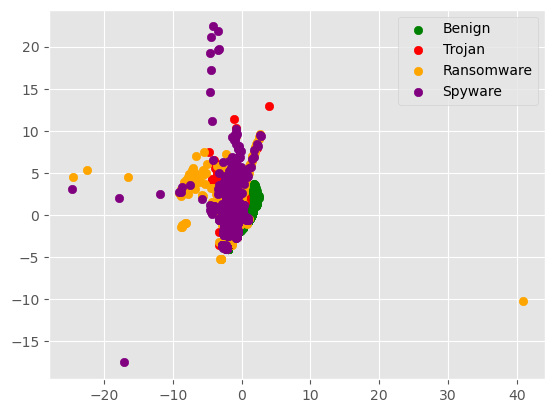

In [434]:
plt.scatter(dataset2D[dataset2D.Category=="Benign"]["Principal Component 1"], dataset2D[dataset2D.Category=="Benign"]["Principal Component 2"], color= "green", label= "Benign")
plt.scatter(dataset2D[dataset2D.Category=="Trojan"]["Principal Component 1"], dataset2D[dataset2D.Category=="Trojan"]["Principal Component 2"], color= "red", label= "Trojan")
plt.scatter(dataset2D[dataset2D.Category=="Ransomware"]["Principal Component 1"], dataset2D[dataset2D.Category=="Ransomware"]["Principal Component 2"], color= "orange", label= "Ransomware")
plt.scatter(dataset2D[dataset2D.Category=="Spyware"]["Principal Component 1"], dataset2D[dataset2D.Category=="Spyware"]["Principal Component 2"], color= "purple", label= "Spyware")
plt.legend()

### Clustering the data (Malware vs Benign)

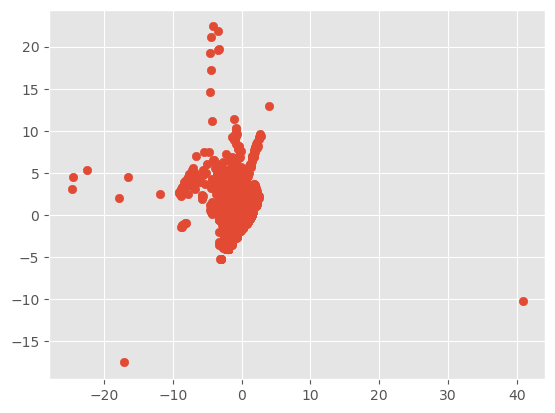

In [435]:
plt.scatter(dataset2D["Principal Component 1"],dataset2D["Principal Component 2"])

In [436]:
#copying the dataframe to improve organization
datasetCluster2= dataset2D.copy()

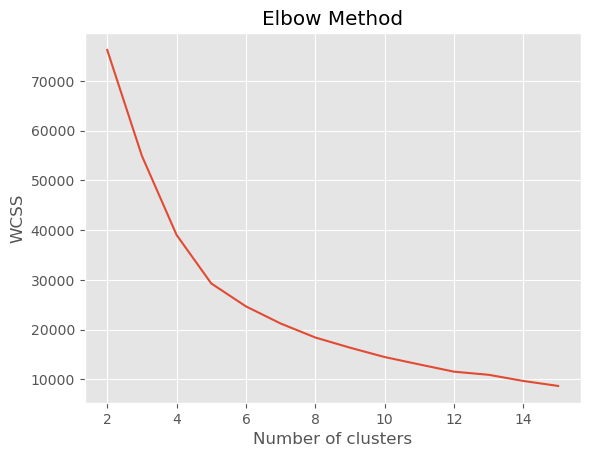

In [437]:
wcss = []

for i in range(2, 16):
    #model = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    model =KMeans(n_clusters=i)
    model.fit(dataset2D[["Principal Component 1", "Principal Component 2"]])
    wcss.append(model.inertia_)
plt.plot(range(2, 16), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
#the elbow method shows that the optimum number of cluster should be between 6 and 8 clusters

In [438]:
#Initializing the kmeans model for 2 clusters(benign and malware)
kmeans2=KMeans(n_clusters=2, random_state=1)
y2_pred=kmeans2.fit_predict(dataset2D[["Principal Component 1", "Principal Component 2"]])

In [439]:
#organazing a dataframe to produce better visualizations
datasetCluster2["Cluster"]=y2_pred
datasetCluster2["Category"]= dataset["Category"]
datasetCluster2["Class"]= dataset["Class"]
datasetCluster2["Family"]= dataset["Family"]
datasetCluster2

Principal Component 1  Principal Component 2    Category    Class  \
0                  -0.384381               0.455244      Benign   Benign   
1                   0.314769               1.077953      Benign   Benign   
2                  -0.247424              -1.495562      Benign   Benign   
3                  -0.080652              -1.414274      Benign   Benign   
4                   0.372266               0.712944      Benign   Benign   
...                      ...                    ...         ...      ...   
58591              -0.700137              -0.499919  Ransomware  Malware   
58592              -0.643105              -0.780963  Ransomware  Malware   
58593              -0.623476              -0.468494  Ransomware  Malware   
58594              -0.610382              -0.590926  Ransomware  Malware   
58595              -0.719310              -0.316812  Ransomware  Malware   

       Family  Cluster  
0      Benign        0  
1      Benign        1  
2      Benign        0  
3      Benign        0  
4      Benign        1  
...       ...      ...  
58591   Shade        0  
58592   Shade        0  
58593   Shade        0  
58594   Shade        0  
58595   Shade        0  

[58596 rows x 6 columns]

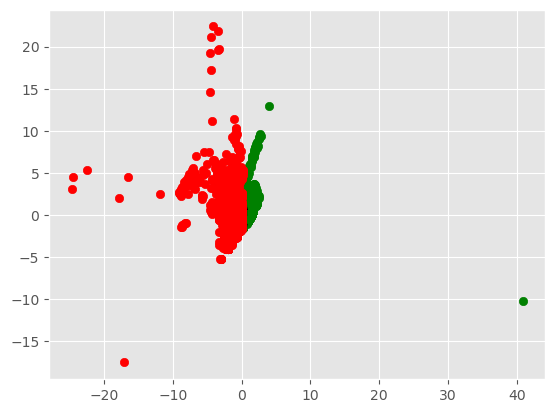

In [635]:
#0 for malware, 1 for benign
#green for benign, red for malware
Cluster1= datasetCluster2[datasetCluster2.Cluster==1]
Cluster0= datasetCluster2[datasetCluster2.Cluster==0]

plt.scatter(Cluster1["Principal Component 1"], Cluster1["Principal Component 2"], color="green", marker="s")
plt.scatter(Cluster0["Principal Component 1"], Cluster0["Principal Component 2"], color="red", marker="^")

In [441]:
datasetCluster2[datasetCluster2.Cluster==0].Class.value_counts()

Malware    29116
Benign      3742
Name: Class, dtype: int64

In [442]:
datasetCluster2[datasetCluster2.Cluster==1].Class.value_counts()

Benign     25556
Malware      182
Name: Class, dtype: int64

In [443]:
#overall kmeans accuracy
accuracy0Malware(datasetCluster2)

Accuracy: 93.30329715338931 % 
 False Positive rate: 0.4915011263567479 %


Boolean Series key will be reindexed to match DataFrame index.


In [444]:
#Creating two datasets, one for the malware, other for the benign
Malware=datasetCluster2[datasetCluster2.Class== "Malware"]
Benign = datasetCluster2[datasetCluster2.Class== "Benign"]
#plt.scatter(Cluster1["Principal Component 1"], Cluster1["Principal Component 2"], color="green", marker="s")

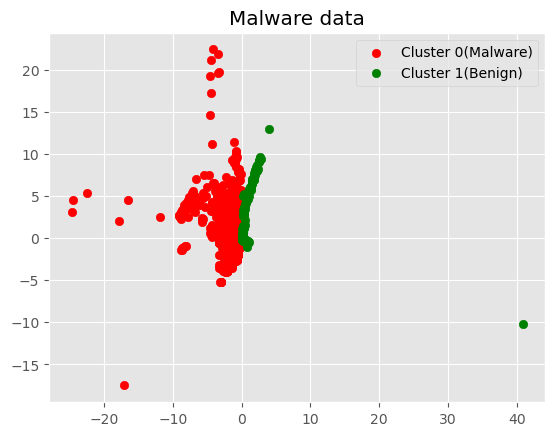

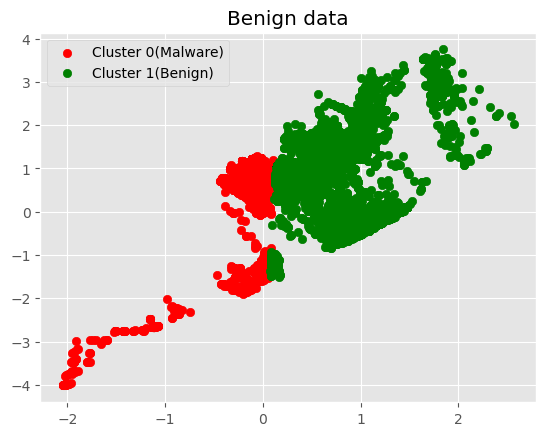

In [445]:
#Scatter plot to visualize the distribution of the malware data among the two clusters
plt.scatter(Malware[Malware.Cluster==0]["Principal Component 1"], Malware[Malware.Cluster==0]["Principal Component 2"], color="red")
plt.scatter(Malware[Malware.Cluster==1]["Principal Component 1"], Malware[Malware.Cluster==1]["Principal Component 2"], color="green")
plt.title("Malware data")
plt.legend(["Cluster 0(Malware)", "Cluster 1(Benign)"])
plt.show()

#Scatter plot to visualize the distribution of the benign data among the two clusters
plt.scatter(Benign[Benign.Cluster==0]["Principal Component 1"], Benign[Benign.Cluster==0]["Principal Component 2"], color="red")
plt.scatter(Benign[Benign.Cluster==1]["Principal Component 1"], Benign[Benign.Cluster==1]["Principal Component 2"], color="green")
plt.title("Benign data")
plt.legend(["Cluster 0(Malware)", "Cluster 1(Benign)"])
plt.show()

### Clustering the data (Malware types)

In [446]:
datasetCluster4= dataset2D.copy()

In [447]:
kmeans4=KMeans(n_clusters=4, random_state=1)
y4_pred=kmeans4.fit_predict(dataset2D[["Principal Component 1", "Principal Component 2"]])
datasetCluster4["Cluster"]=y4_pred
datasetCluster4["Category"]= dataset["Category"]
datasetCluster4["Class"]= dataset["Class"]
datasetCluster4["Family"]= dataset["Family"]
datasetCluster4

Principal Component 1  Principal Component 2    Category    Class  \
0                  -0.384381               0.455244      Benign   Benign   
1                   0.314769               1.077953      Benign   Benign   
2                  -0.247424              -1.495562      Benign   Benign   
3                  -0.080652              -1.414274      Benign   Benign   
4                   0.372266               0.712944      Benign   Benign   
...                      ...                    ...         ...      ...   
58591              -0.700137              -0.499919  Ransomware  Malware   
58592              -0.643105              -0.780963  Ransomware  Malware   
58593              -0.623476              -0.468494  Ransomware  Malware   
58594              -0.610382              -0.590926  Ransomware  Malware   
58595              -0.719310              -0.316812  Ransomware  Malware   

       Family  Cluster  
0      Benign        0  
1      Benign        3  
2      Benign        0  
3      Benign        0  
4      Benign        3  
...       ...      ...  
58591   Shade        0  
58592   Shade        0  
58593   Shade        0  
58594   Shade        0  
58595   Shade        0  

[58596 rows x 6 columns]

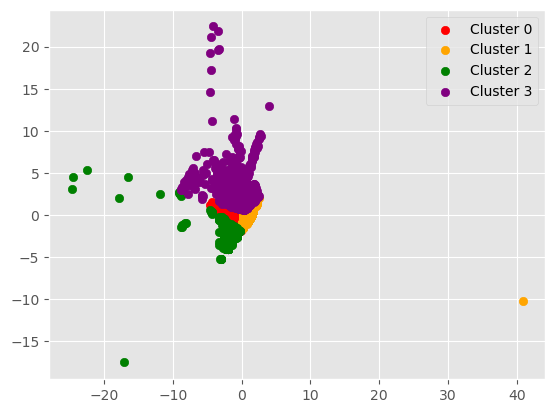

In [459]:
Cluster40= datasetCluster4[datasetCluster4.Cluster==0]
Cluster41= datasetCluster4[datasetCluster4.Cluster==1]
Cluster42= datasetCluster4[datasetCluster4.Cluster==2]
Cluster43= datasetCluster4[datasetCluster4.Cluster==3]

plt.scatter(Cluster40["Principal Component 1"], Cluster40["Principal Component 2"], color="red", label="Cluster 0")
plt.scatter(Cluster41["Principal Component 1"], Cluster41["Principal Component 2"], color="orange", label="Cluster 1")
plt.scatter(Cluster42["Principal Component 1"], Cluster42["Principal Component 2"], color="green", label="Cluster 2")
plt.scatter(Cluster43["Principal Component 1"], Cluster43["Principal Component 2"], color="purple", label="Cluster 3")
plt.legend()

In [458]:
datasetCluster4[datasetCluster4.Cluster==1].Category.value_counts()

Benign        21615
Spyware          27
Ransomware       11
Trojan           10
Name: Category, dtype: int64

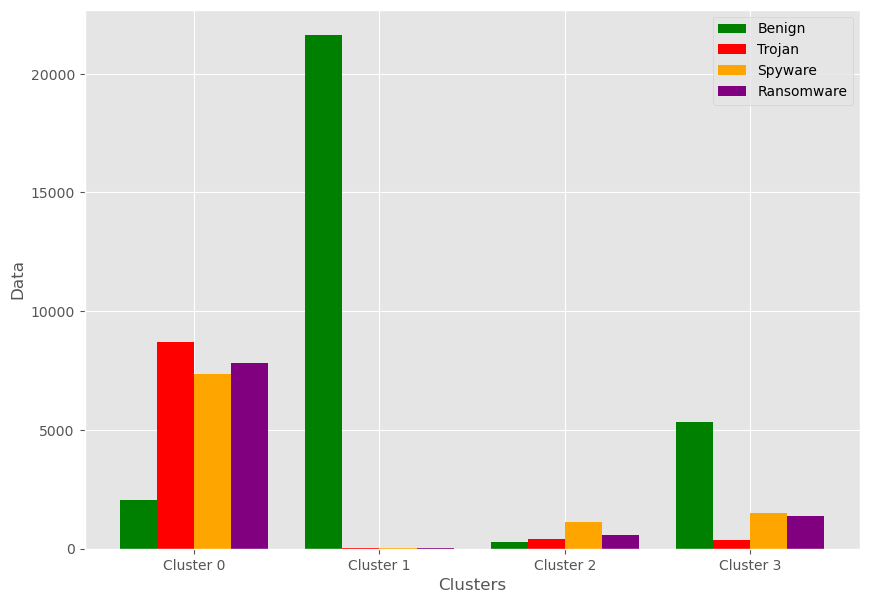

In [457]:
# cluster 0, cluster 1, cluster 2, cluster 3
benign=[2039,21615,296,5348]
trojan=[8705,10,401, 371]
spyware=[7376,27,1131, 1486]
ransomware=[7823,11,564, 1393]
xpos=np.arange(len(benign))

style.use("ggplot")
plt.figure(figsize=(10,7))
barwidth=0.2
plt.bar(xpos,benign, color='green', width= barwidth, label="Benign")
plt.bar(xpos+0.2,trojan, color='red', width= barwidth, label="Trojan")
plt.bar(xpos+0.4,spyware, color='orange', width= barwidth, label="Spyware")
plt.bar(xpos+0.6,ransomware, color='purple', width= barwidth, label="Ransomware")
plt.xlabel("Clusters")
plt.xticks(xpos+0.3,("Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"))
plt.ylabel("Data")
plt.legend()


In [32]:
"""
plt.figure(figsize=(10,7))
barwidth=0.2
plt.bar(xpos,benign, color='green', width= barwidth, label="Benign")
plt.bar(xpos,trojan, bottom=benign, color='red', width= barwidth, label="Trojan")
plt.bar(xpos,spyware, bottom=trojan, color='orange', width= barwidth, label="Spyware")
plt.bar(xpos,ransomware, bottom=spyware, color='purple', width= barwidth, label="Ransomware")
plt.xlabel("Clusters")
plt.xticks(xpos,("Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"))
plt.ylabel("Data")
plt.legend()
"""

'\nplt.figure(figsize=(10,7))\nbarwidth=0.2\nplt.bar(xpos,benign, color=\'green\', width= barwidth, label="Benign")\nplt.bar(xpos,trojan, bottom=benign, color=\'red\', width= barwidth, label="Trojan")\nplt.bar(xpos,spyware, bottom=trojan, color=\'orange\', width= barwidth, label="Spyware")\nplt.bar(xpos,ransomware, bottom=spyware, color=\'purple\', width= barwidth, label="Ransomware")\nplt.xlabel("Clusters")\nplt.xticks(xpos,("Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"))\nplt.ylabel("Data")\nplt.legend()\n'

In [33]:
datasetCluster4

Principal Component 1  Principal Component 2    Category    Class  \
0                  -0.454164               0.011136      Benign   Benign   
1                   0.871756              -0.149260      Benign   Benign   
2                   0.423269              -0.910884      Benign   Benign   
3                  -0.549543              -1.158069      Benign   Benign   
4                   0.839404               1.208529      Benign   Benign   
...                      ...                    ...         ...      ...   
58591              -0.889130              -0.636817  Ransomware  Malware   
58592              -1.150324              -1.149242  Ransomware  Malware   
58593              -1.021942              -0.185218  Ransomware  Malware   
58594              -0.784899              -0.968064  Ransomware  Malware   
58595              -1.005086               0.010837  Ransomware  Malware   

       Family  Cluster  
0      Benign        3  
1      Benign        2  
2      Benign        2  
3      Benign        0  
4      Benign        2  
...       ...      ...  
58591   Shade        0  
58592   Shade        0  
58593   Shade        0  
58594   Shade        0  
58595   Shade        3  

[58596 rows x 6 columns]

### Clustering the data( all malware families)

In [460]:
Families=dataset.Family.unique()

In [461]:
len(Families)

16

In [462]:
datasetCluster16= dataset2D.copy()

In [463]:
kmeans16=KMeans(n_clusters=16, random_state=1)
y16_pred=kmeans16.fit_predict(dataset2D[["Principal Component 1", "Principal Component 2"]])

In [464]:
datasetCluster16["Cluster"]=y16_pred
datasetCluster16["Category"]= dataset["Category"]
datasetCluster16["Class"]= dataset["Class"]
datasetCluster16["Family"]= dataset["Family"]
datasetCluster16

Principal Component 1  Principal Component 2    Category    Class  \
0                  -0.384381               0.455244      Benign   Benign   
1                   0.314769               1.077953      Benign   Benign   
2                  -0.247424              -1.495562      Benign   Benign   
3                  -0.080652              -1.414274      Benign   Benign   
4                   0.372266               0.712944      Benign   Benign   
...                      ...                    ...         ...      ...   
58591              -0.700137              -0.499919  Ransomware  Malware   
58592              -0.643105              -0.780963  Ransomware  Malware   
58593              -0.623476              -0.468494  Ransomware  Malware   
58594              -0.610382              -0.590926  Ransomware  Malware   
58595              -0.719310              -0.316812  Ransomware  Malware   

       Family  Cluster  
0      Benign        0  
1      Benign        8  
2      Benign        6  
3      Benign        6  
4      Benign        8  
...       ...      ...  
58591   Shade        6  
58592   Shade        6  
58593   Shade        6  
58594   Shade        6  
58595   Shade       11  

[58596 rows x 6 columns]

In [465]:
datasetCluster16.Cluster.value_counts()

1     20891
11    13434
0      6820
6      4861
8      4399
7      2506
15     1843
2      1838
3       814
4       572
14      486
9        64
5        53
10        8
13        6
12        1
Name: Cluster, dtype: int64

Text(0.5, 1.0, 'Clustering 16 families')

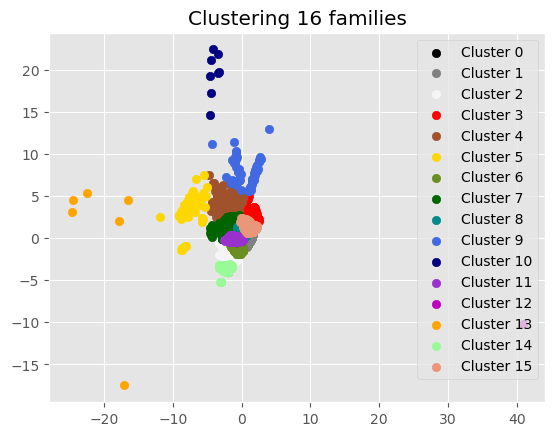

In [469]:
colors=["black","gray","whitesmoke","red","sienna","gold", "olivedrab", "darkgreen", "darkcyan","royalblue", "navy","darkorchid","m","orange","palegreen","darksalmon"]
label=["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3","Cluster 4" ,"Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8", "Cluster 9", "Cluster 10", "Cluster 11","Cluster 12", "Cluster 13", "Cluster 14", "Cluster 15"]
for i in range(len(Families)):
    plt.scatter(datasetCluster16[datasetCluster16.Cluster== i]["Principal Component 1"],datasetCluster16[datasetCluster16.Cluster== i]["Principal Component 2"], color= colors[i], label= label[i])
plt.legend()    
plt.title("Clustering 16 families")    
    

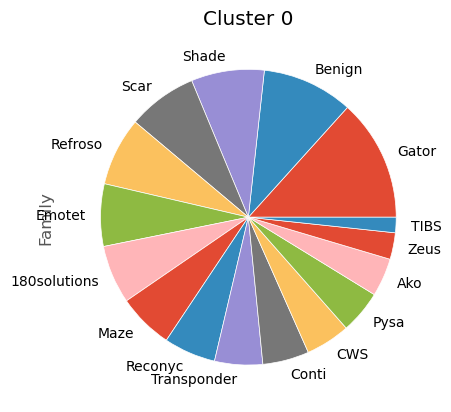

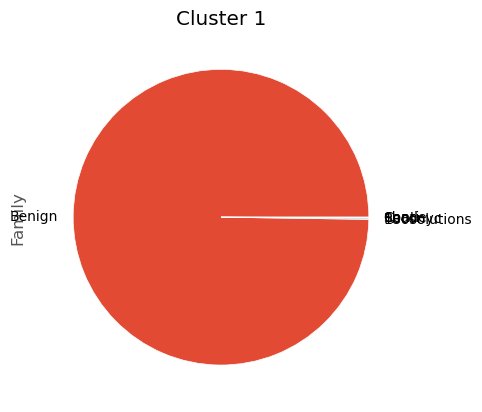

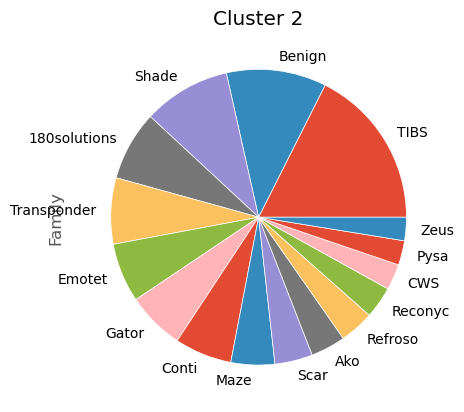

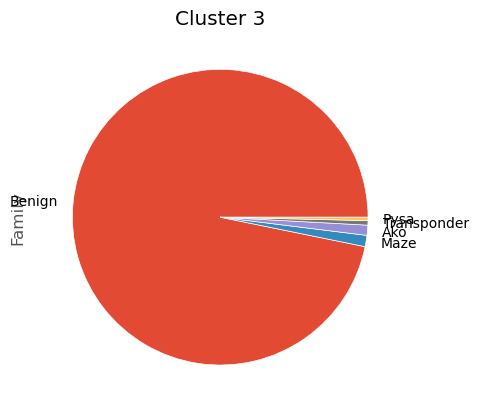

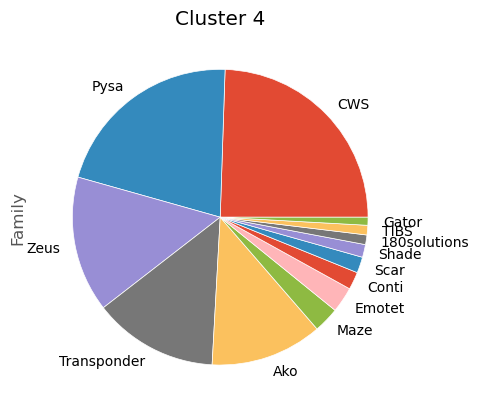

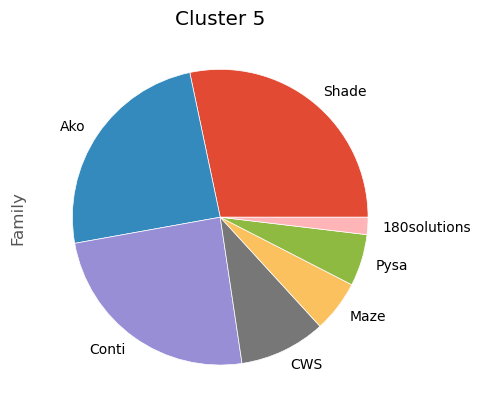

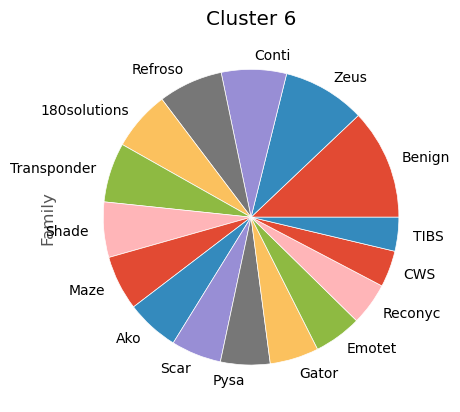

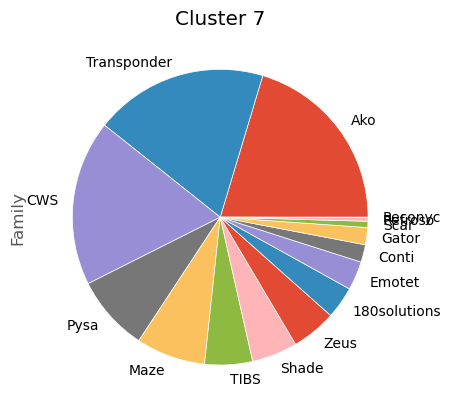

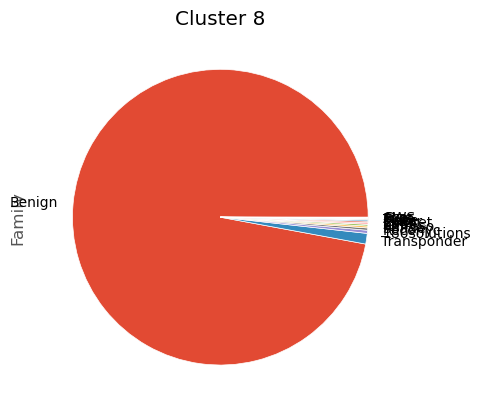

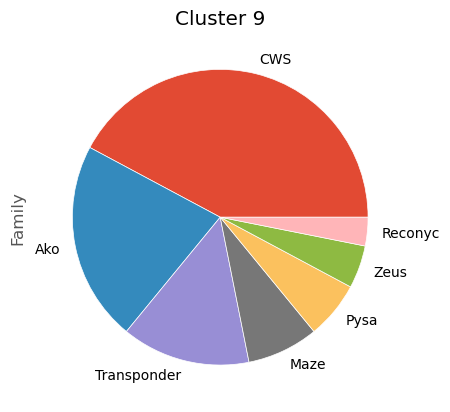

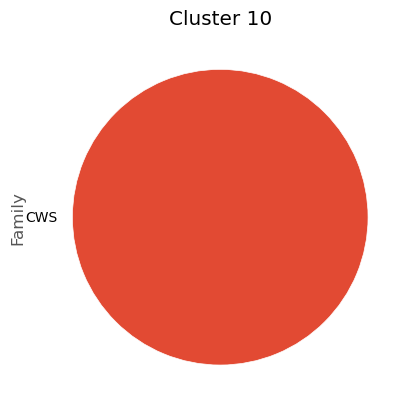

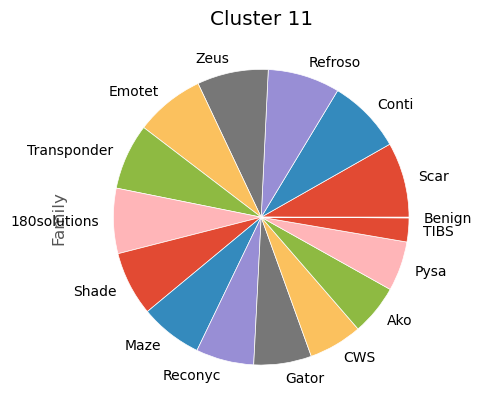

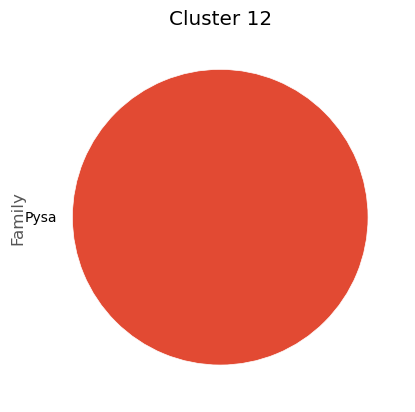

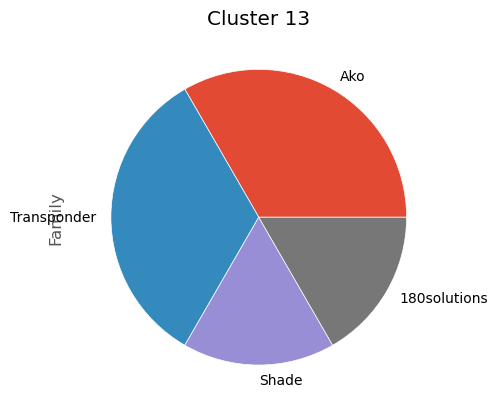

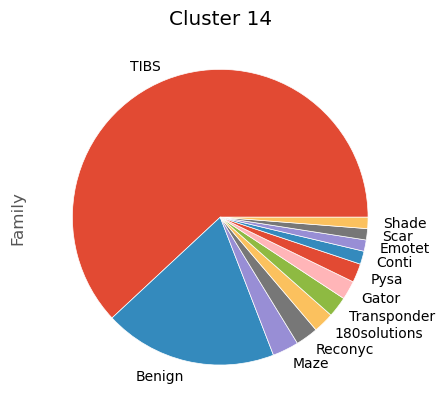

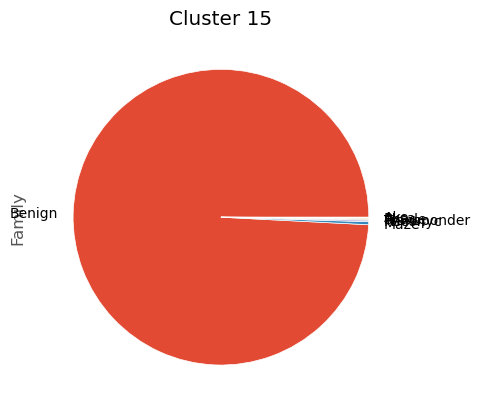

In [471]:
for i in range(len(Families)):
    datasetCluster16[datasetCluster16.Cluster==i].Family.value_counts().plot.pie(wedgeprops={'edgecolor': 'white'})
    plt.title(label[i])
    plt.show()



In [42]:
len(Families)

16

In [43]:
datasetCluster16[datasetCluster16.Cluster==5].Family.value_counts()

Ako            27
Transponder    27
CWS            21
Pysa           13
Maze            8
Reconyc         2
Scar            2
Name: Family, dtype: int64

## Supervised Clustering

### Obtaining SHAP values

In [472]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from datetime import datetime


shap.initjs()

In [474]:
dataset

Category  pslist.nproc  pslist.nppid  pslist.avg_threads  \
0          Benign            45            17           10.555556   
1          Benign            47            19           11.531915   
2          Benign            40            14           14.725000   
3          Benign            32            13           13.500000   
4          Benign            42            16           11.452381   
...           ...           ...           ...                 ...   
58591  Ransomware            37            15           10.108108   
58592  Ransomware            37            14            9.945946   
58593  Ransomware            38            15            9.842105   
58594  Ransomware            37            15           10.243243   
58595  Ransomware            38            15            9.868421   

       pslist.avg_handlers  dlllist.ndlls  dlllist.avg_dlls_per_proc  \
0               202.844444           1694                  38.500000   
1               242.234043           2074                  44.127660   
2               288.225000           1932                  48.300000   
3               264.281250           1445                  45.156250   
4               281.333333           2067                  49.214286   
...                    ...            ...                        ...   
58591           215.486487           1453                  39.270270   
58592           190.216216           1347                  36.405405   
58593           210.026316           1448                  38.105263   
58594           215.513513           1452                  39.243243   
58595           213.026316           1487                  39.131579   

       handles.nhandles  handles.avg_handles_per_proc  handles.nfile  \
0                  9129                    212.302326            670   
1                 11385                    242.234043            840   
2                 11529                    288.225000           1050   
3                  8457                    264.281250            630   
4                 11816                    281.333333            908   
...                 ...                           ...            ...   
58591              7973                    215.486487            630   
58592              7038                    190.216216            603   
58593              7982                    215.729730            624   
58594              7974                    215.513513            632   
58595              8095                    213.026316            637   

       handles.nevent  handles.ndesktop  handles.nkey  handles.nthread  \
0                3161                46           716              887   
1                3761                51          1011             1030   
2                3996                45           784             1241   
3                2961                36           654              792   
4                3834                45          1252              942   
...               ...               ...           ...              ...   
58591            2819                40           668              664   
58592            2394                39           555              624   
58593            2816                40           673              661   
58594            2819                40           668              667   
58595            2843                41           683              669   

       handles.ndirectory  handles.nsemaphore  handles.ntimer  \
0                     104                 671             125   
1                     117                 766             148   
2                     100                 645             138   
3                      83                 567             127   
4                     103                 825             135   
...                   ...                 ...             ...   
58591                  92                 596             113   
58592                  91                

In [476]:
#0 for benign, 1 for malware
#0 for benign, 1 for ransomware, 2 for spyware, 3 for Trojan
#enconding the target variables
dataset2 = dataset.copy()
Class = ["Benign", "Malware"]
Category=['Benign', 'Ransomware', 'Spyware', 'Trojan']
Family= ['Benign', 'Ako', 'Conti', 'Maze', 'Pysa', 'Shade', '180solutions',
       'CWS', 'Gator', 'TIBS', 'Transponder', 'Emotet', 'Reconyc',
       'Refroso', 'Scar', 'Zeus']
dataset2.drop(corr_features, axis=1, inplace= True)
Code1=[0,1]
Code2=[0,1,2,3]
Code3=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

dataset2.Class.replace(Class, Code1, inplace= True)
dataset2.Category.replace(Category, Code2, inplace= True)
dataset2.Family.replace(Family, Code3, inplace= True)


### Training a xgboost model (Malware vs Benign)

In [478]:
X = dataset2.drop(["Category","Class","Family"], axis=1)
Y = dataset2["Class"]

x_train,x_test, y_train,y_test= train_test_split(X, Y, test_size=0.2, random_state=0)

In [479]:
#param optimization for gridsearch
params = {
    "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    "max_depth": [5,10,15,20],
    "min_child_weight": [1,3,5,7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
    "early_stopping_rounds": [25,50,100],
    "n_estimators": [100,200,500]
}

In [480]:
Classifier= xgb.XGBClassifier()
random_search=RandomizedSearchCV(Classifier, param_distributions=params, n_iter=5, n_jobs=-1,cv=5)
#gridsearch= GridSearchCV(Classifier, param_grid= params)

In [481]:
start_time=timer(None)
random_search.fit(x_train,y_train, eval_set=[(x_test, y_test)])
timer(start_time)

[0]	validation_0-logloss:0.44282
[1]	validation_0-logloss:0.30026
[2]	validation_0-logloss:0.21104
[3]	validation_0-logloss:0.15359
[4]	validation_0-logloss:0.11122
[5]	validation_0-logloss:0.08118
[6]	validation_0-logloss:0.06005
[7]	validation_0-logloss:0.04465
[8]	validation_0-logloss:0.03464
[9]	validation_0-logloss:0.03198
[10]	validation_0-logloss:0.02413
[11]	validation_0-logloss:0.01821
[12]	validation_0-logloss:0.01395
[13]	validation_0-logloss:0.01072
[14]	validation_0-logloss:0.00833
[15]	validation_0-logloss:0.00682
[16]	validation_0-logloss:0.00581
[17]	validation_0-logloss:0.00470
[18]	validation_0-logloss:0.00384
[19]	validation_0-logloss:0.00332
[20]	validation_0-logloss:0.00278
[21]	validation_0-logloss:0.00242
[22]	validation_0-logloss:0.00219
[23]	validation_0-logloss:0.00203
[24]	validation_0-logloss:0.00187
[25]	validation_0-logloss:0.00172
[26]	validation_0-logloss:0.00158
[27]	validation_0-logloss:0.00148
[28]	validation_0-logloss:0.00142
[29]	validation_0-loglos

In [482]:
random_search.best_params_

{'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 20,
 'learning_rate': 0.3,
 'gamma': 0.3,
 'early_stopping_rounds': 25,
 'colsample_bytree': 0.3}

In [487]:
Classifier= xgb.XGBClassifier(n_estimators=100,
 min_child_weight=3,
 max_depth=10,
 learning_rate=0.2,
 gamma=0.4,
 early_stopping_rounds=25,
 colsample_bytree=0.3)
Classifier.fit(x_train,y_train,eval_set=[(x_test, y_test)])

[0]	validation_0-logloss:0.51697
[1]	validation_0-logloss:0.39536
[2]	validation_0-logloss:0.30862
[3]	validation_0-logloss:0.24633
[4]	validation_0-logloss:0.19627
[5]	validation_0-logloss:0.15735
[6]	validation_0-logloss:0.12716
[7]	validation_0-logloss:0.10319
[8]	validation_0-logloss:0.08602
[9]	validation_0-logloss:0.08070
[10]	validation_0-logloss:0.06606
[11]	validation_0-logloss:0.05402
[12]	validation_0-logloss:0.04439
[13]	validation_0-logloss:0.03650
[14]	validation_0-logloss:0.03001
[15]	validation_0-logloss:0.02547
[16]	validation_0-logloss:0.02203
[17]	validation_0-logloss:0.01836
[18]	validation_0-logloss:0.01530
[19]	validation_0-logloss:0.01297
[20]	validation_0-logloss:0.01083
[21]	validation_0-logloss:0.00914
[22]	validation_0-logloss:0.00785
[23]	validation_0-logloss:0.00681
[24]	validation_0-logloss:0.00588
[25]	validation_0-logloss:0.00506
[26]	validation_0-logloss:0.00440
[27]	validation_0-logloss:0.00384
[28]	validation_0-logloss:0.00350
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=25, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [486]:
#Checking accuracy
y_predxgb= Classifier.predict(x_test)
predictions = [round(value) for value in y_predxgb]
accuracy = accuracy_score(y_test, predictions)
accuracy

0.999914675767918

### Computing SHAP values

In [393]:
#Classifier= xgb.XGBClassifier()
#Classifier.fit(x_train,y_train,eval_set=[(x_test, y_test)])

[0]	validation_0-logloss:0.43807
[1]	validation_0-logloss:0.29718
[2]	validation_0-logloss:0.20842
[3]	validation_0-logloss:0.14903
[4]	validation_0-logloss:0.10772
[5]	validation_0-logloss:0.07856
[6]	validation_0-logloss:0.05769
[7]	validation_0-logloss:0.04259
[8]	validation_0-logloss:0.03159
[9]	validation_0-logloss:0.02356
[10]	validation_0-logloss:0.01767
[11]	validation_0-logloss:0.01336
[12]	validation_0-logloss:0.01018
[13]	validation_0-logloss:0.00780
[14]	validation_0-logloss:0.00605
[15]	validation_0-logloss:0.00476
[16]	validation_0-logloss:0.00379
[17]	validation_0-logloss:0.00307
[18]	validation_0-logloss:0.00254
[19]	validation_0-logloss:0.00215
[20]	validation_0-logloss:0.00187
[21]	validation_0-logloss:0.00166
[22]	validation_0-logloss:0.00151
[23]	validation_0-logloss:0.00141
[24]	validation_0-logloss:0.00133
[25]	validation_0-logloss:0.00130
[26]	validation_0-logloss:0.00127
[27]	validation_0-logloss:0.00125
[28]	validation_0-logloss:0.00123
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [488]:
start_time=timer(None)
explainer = shap.Explainer(Classifier, X, seed=1)
shap_values = explainer(X)
timer(start_time)

 98%|===================| 57401/58596 [00:42<00:00]        


 Time taken: 0 hours 0 minutes and 42 seconds.


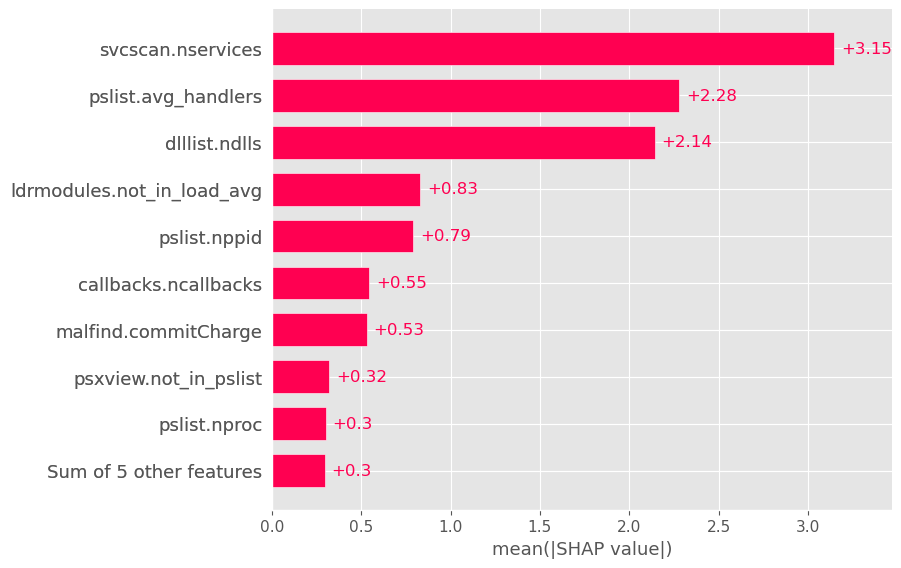

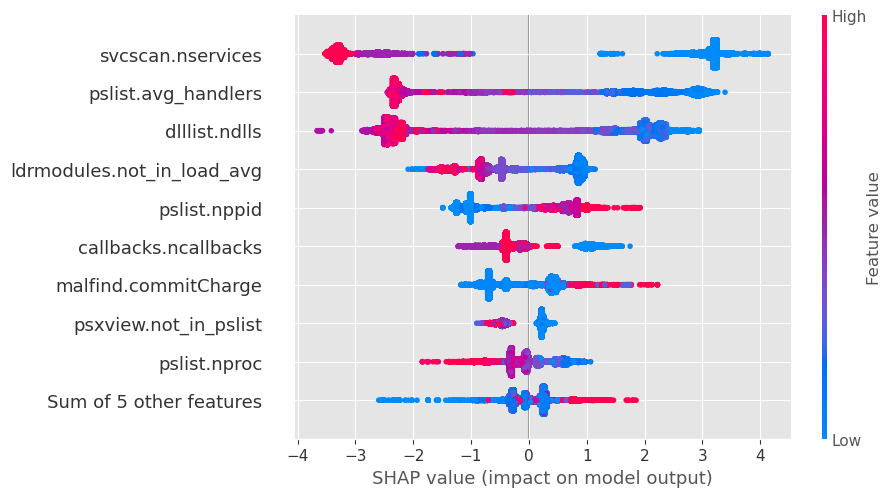

In [490]:
#Visualization of the mean SHAP values
shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)

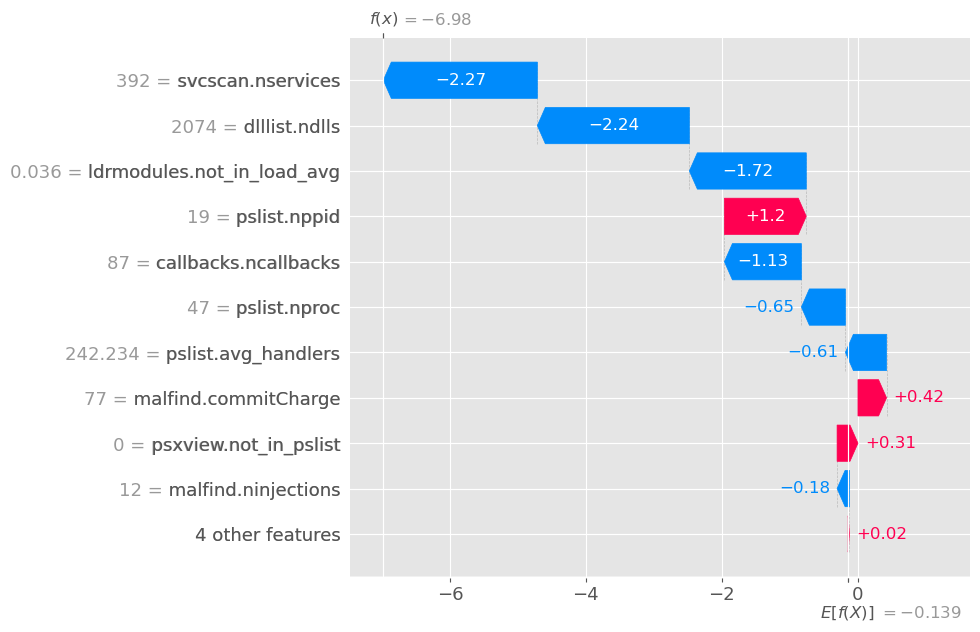

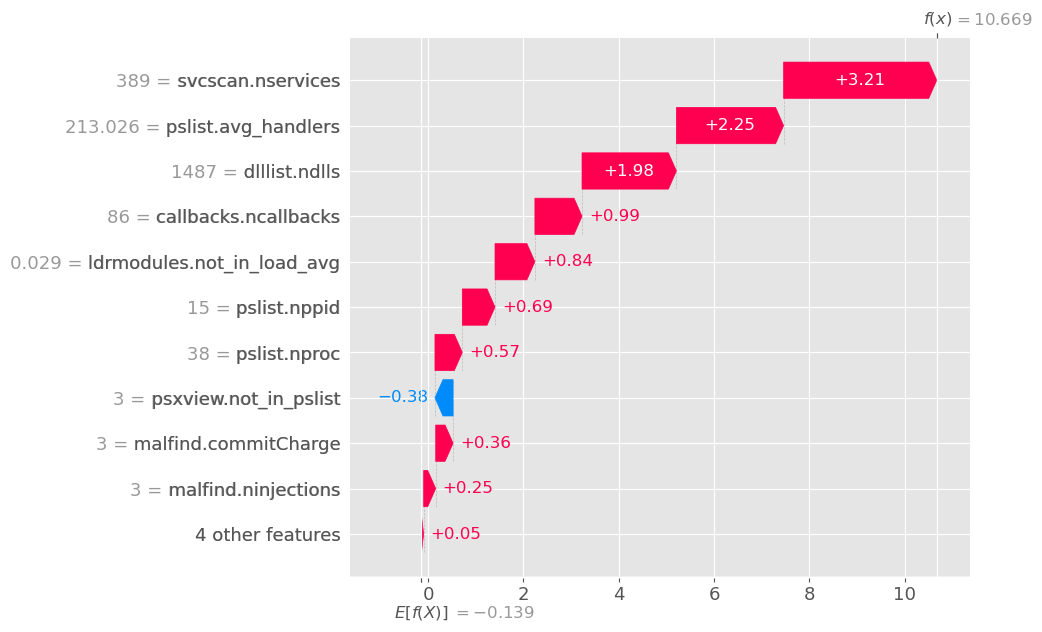

In [491]:
#Visualization of the SHAP values for both 1 malware and 1 benign data
shap.plots.waterfall(shap_values[1], max_display=11)

shap.plots.waterfall(shap_values[58595], max_display=11)

### Reducing SHAP values to 2D

In [492]:
pcaShap = PCA(n_components=2, random_state= 1)
ScalerShap= StandardScaler()

In [493]:
SHAPDF= ScalerShap.fit_transform(shap_values.values)
SHAP2D=pcaShap.fit_transform(SHAPDF)

SHAP2D = np.array(SHAP2D)
SHAPDF= pd.DataFrame(SHAP2D, columns=["Principal Component 1", "Principal Component 2"])

print(pcaShap.explained_variance_ratio_*100)
SHAPDF

[57.87521194 11.45634651]


Principal Component 1  Principal Component 2
0                   0.999960              -1.323467
1                  -1.846059              -0.774108
2                  -2.254213               2.385135
3                  -0.673349               0.436102
4                  -1.633874              -1.455834
...                      ...                    ...
58591               2.859138               0.702299
58592               2.140614               1.021668
58593               2.912440              -0.303302
58594               2.585030               0.794301
58595               3.114090              -0.410755

[58596 rows x 2 columns]

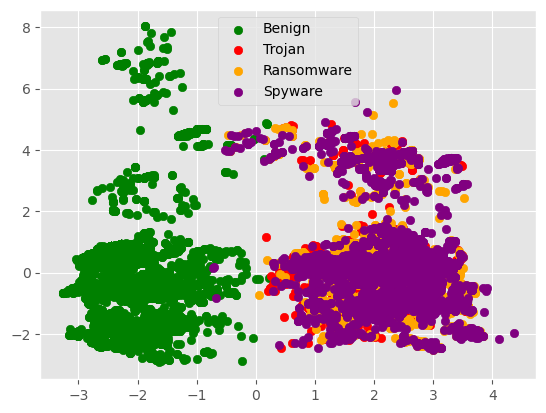

In [494]:
SHAPDF["Class"]=dataset.Class
SHAPDF["Category"]=dataset.Category

plt.scatter(SHAPDF[SHAPDF.Category=="Benign"]["Principal Component 1"], SHAPDF[SHAPDF.Category=="Benign"]["Principal Component 2"], color= "green", label= "Benign")
plt.scatter(SHAPDF[SHAPDF.Category=="Trojan"]["Principal Component 1"], SHAPDF[SHAPDF.Category=="Trojan"]["Principal Component 2"], color= "red", label= "Trojan")
plt.scatter(SHAPDF[SHAPDF.Category=="Ransomware"]["Principal Component 1"], SHAPDF[SHAPDF.Category=="Ransomware"]["Principal Component 2"], color= "orange", label= "Ransomware")
plt.scatter(SHAPDF[SHAPDF.Category=="Spyware"]["Principal Component 1"], SHAPDF[SHAPDF.Category=="Spyware"]["Principal Component 2"], color= "purple", label= "Spyware")
plt.legend()

### Applying clustering to the SHAP data

In [495]:
kmeansShap=KMeans(n_clusters=2, random_state=1)

In [496]:
ShapCluster2pred=kmeansShap.fit_predict(SHAPDF[["Principal Component 1", "Principal Component 2"]])
SHAPDF["Cluster"]=ShapCluster2pred
SHAPDF

#Cluster 0 malware, Cluster 1 Benign

Principal Component 1  Principal Component 2    Class    Category  \
0                   0.999960              -1.323467   Benign      Benign   
1                  -1.846059              -0.774108   Benign      Benign   
2                  -2.254213               2.385135   Benign      Benign   
3                  -0.673349               0.436102   Benign      Benign   
4                  -1.633874              -1.455834   Benign      Benign   
...                      ...                    ...      ...         ...   
58591               2.859138               0.702299  Malware  Ransomware   
58592               2.140614               1.021668  Malware  Ransomware   
58593               2.912440              -0.303302  Malware  Ransomware   
58594               2.585030               0.794301  Malware  Ransomware   
58595               3.114090              -0.410755  Malware  Ransomware   

       Cluster  
0            0  
1            1  
2            1  
3            1  
4            1  
...        ...  
58591        0  
58592        0  
58593        0  
58594        0  
58595        0  

[58596 rows x 5 columns]

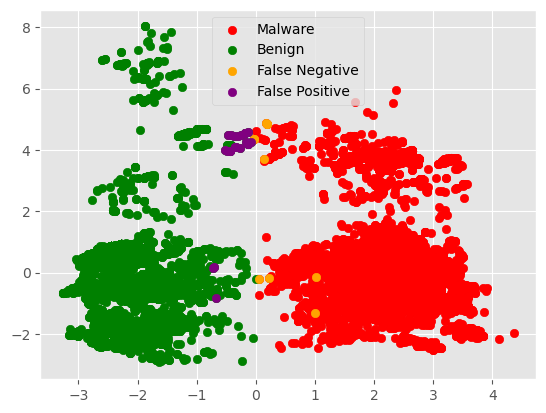

In [497]:
plt.scatter(SHAPDF[SHAPDF.Cluster==0]["Principal Component 1"],SHAPDF[SHAPDF.Cluster==0]["Principal Component 2"], color="red", label="Malware")
plt.scatter(SHAPDF[SHAPDF.Cluster==1]["Principal Component 1"],SHAPDF[SHAPDF.Cluster==1]["Principal Component 2"], color="green", label="Benign")
plt.scatter(SHAPDF[(SHAPDF.Cluster==0) & (SHAPDF.Class== "Benign")]["Principal Component 1"],SHAPDF[(SHAPDF.Cluster==0) & (SHAPDF.Class== "Benign")]["Principal Component 2"], color= "orange", label ="False Negative")
plt.scatter(SHAPDF[(SHAPDF.Cluster==1) & (SHAPDF.Class== "Malware")]["Principal Component 1"],SHAPDF[(SHAPDF.Cluster==1) & (SHAPDF.Class== "Malware")]["Principal Component 2"], color= "purple", label ="False Positive")
plt.legend()


In [498]:
accuracy0Malware(SHAPDF)

Accuracy: 99.94026896033859 % 
 False Positive rate: 0.08533005665915763 %


Boolean Series key will be reindexed to match DataFrame index.


### Training a xgboost model (Ransomware x Trojan x Spyware vs Benign)

In [500]:
#0 for benign, 1 for ransomware, 2 for spyware, 3 for Trojan
X1 = dataset2.drop(["Category","Class","Family"], axis=1)
Y1 = dataset2["Category"]

x1_train,x1_test, y1_train,y1_test= train_test_split(X1, Y1, test_size=0.2, random_state=0)

In [501]:
Classifier1= xgb.XGBClassifier()
random_search1=RandomizedSearchCV(Classifier1, param_distributions=params, n_iter=5, n_jobs=-1,cv=5)

In [509]:
start_time=timer(None)
random_search1.fit(x1_train,y1_train, eval_set=[(x1_test, y1_test)])
timer(start_time)

[0]	validation_0-mlogloss:1.20496
[1]	validation_0-mlogloss:1.06953
[2]	validation_0-mlogloss:0.96357
[3]	validation_0-mlogloss:0.87481
[4]	validation_0-mlogloss:0.80488
[5]	validation_0-mlogloss:0.74243
[6]	validation_0-mlogloss:0.68940
[7]	validation_0-mlogloss:0.64505
[8]	validation_0-mlogloss:0.60405
[9]	validation_0-mlogloss:0.57466
[10]	validation_0-mlogloss:0.54778
[11]	validation_0-mlogloss:0.52419
[12]	validation_0-mlogloss:0.50240
[13]	validation_0-mlogloss:0.48518
[14]	validation_0-mlogloss:0.46867
[15]	validation_0-mlogloss:0.45731
[16]	validation_0-mlogloss:0.44452
[17]	validation_0-mlogloss:0.43339
[18]	validation_0-mlogloss:0.42452
[19]	validation_0-mlogloss:0.41659
[20]	validation_0-mlogloss:0.40867
[21]	validation_0-mlogloss:0.40146
[22]	validation_0-mlogloss:0.39586
[23]	validation_0-mlogloss:0.39102
[24]	validation_0-mlogloss:0.38680
[25]	validation_0-mlogloss:0.38249
[26]	validation_0-mlogloss:0.37859
[27]	validation_0-mlogloss:0.37611
[28]	validation_0-mlogloss:0.3

In [510]:
random_search1.best_params_

{'n_estimators': 500,
 'min_child_weight': 7,
 'max_depth': 15,
 'learning_rate': 0.15,
 'gamma': 0.0,
 'early_stopping_rounds': 50,
 'colsample_bytree': 0.5}

In [511]:
Classifier1= xgb.XGBClassifier(n_estimators=500,
 min_child_weight=7,
 max_depth=15,
 learning_rate=0.15,
 gamma=0.0,
 early_stopping_rounds=50,
 colsample_bytree=0.5)
Classifier1.fit(x1_train,y1_train,eval_set=[(x1_test, y1_test)])

[0]	validation_0-mlogloss:1.20496
[1]	validation_0-mlogloss:1.06953
[2]	validation_0-mlogloss:0.96357
[3]	validation_0-mlogloss:0.87481
[4]	validation_0-mlogloss:0.80488
[5]	validation_0-mlogloss:0.74243
[6]	validation_0-mlogloss:0.68940
[7]	validation_0-mlogloss:0.64505
[8]	validation_0-mlogloss:0.60405
[9]	validation_0-mlogloss:0.57466
[10]	validation_0-mlogloss:0.54778
[11]	validation_0-mlogloss:0.52419
[12]	validation_0-mlogloss:0.50240
[13]	validation_0-mlogloss:0.48518
[14]	validation_0-mlogloss:0.46867
[15]	validation_0-mlogloss:0.45731
[16]	validation_0-mlogloss:0.44452
[17]	validation_0-mlogloss:0.43339
[18]	validation_0-mlogloss:0.42452
[19]	validation_0-mlogloss:0.41659
[20]	validation_0-mlogloss:0.40867
[21]	validation_0-mlogloss:0.40146
[22]	validation_0-mlogloss:0.39586
[23]	validation_0-mlogloss:0.39102
[24]	validation_0-mlogloss:0.38680
[25]	validation_0-mlogloss:0.38249
[26]	validation_0-mlogloss:0.37859
[27]	validation_0-mlogloss:0.37611
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [512]:
#Checking accuracy
y_predxgb1= Classifier1.predict(x1_test)
predictions1 = [round(value) for value in y_predxgb1]
accuracy1 = accuracy_score(y1_test, predictions1)
accuracy1

0.8495733788395905

### Computing SHAP values

In [513]:
start_time=timer(None)
explainer1 = shap.TreeExplainer(Classifier1, X1)
shap_values1= explainer1(X1)
timer(start_time)

100%|===================| 234382/234384 [94:35<00:00]        


 Time taken: 1 hours 34 minutes and 38 seconds.


In [514]:
pd.DataFrame(shap_values1.values[:, :,2], columns=X1.columns)

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0          0.324270      0.072518             0.587945       0.002387   
1         -0.090265      0.597259             0.339699      -0.387895   
2          0.004596     -0.156534            -0.695469      -0.382922   
3         -0.095770     -0.174602             0.118077       0.620356   
4          0.006363     -0.019710            -0.541406      -0.435211   
...             ...           ...                  ...            ...   
58591     -0.280353     -0.176004             0.188072      -0.344410   
58592     -0.068568     -0.218374             0.428950      -0.062722   
58593     -0.059576     -0.126194             0.479129       0.343375   
58594     -0.051944     -0.111599             0.460518      -0.094779   
58595      0.061341     -0.027208             0.511940       0.281035   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                        0.190759             0.043645             -0.557448   
1                       -0.603834            -0.584519              0.368434   
2                       -0.228518            -0.083275             -0.474475   
3                       -0.073129             0.073942              0.135237   
4                       -0.165511            -0.443657              0.434120   
...                           ...                  ...                   ...   
58591                   -0.503014             0.042076              0.098775   
58592                   -0.123692             0.049891              0.142099   
58593                    0.009585             0.022353              0.122209   
58594                   -0.217546             0.058506              0.130766   
58595                    0.023908             0.081403              0.180942   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                  -0.034580                     -0.000590          0.001141   
1                  -0.021661                     -0.000025          0.000501   
2                  -0.087629                     -0.000177         -0.016451   
3                  -0.061780                      0.000007          0.001800   
4                  -0.004391                     -0.000279         -0.000417   
...                      ...                           ...               ...   
58591              -0.014539                     -0.000254          0.001490   
58592              -0.028195                      0.000004          0.001015   
58593              -0.085374                     -0.000091          0.001714   
58594               0.000241                      0.000002          0.001658   
58595              -0.053331                     -0.000588          0.001279   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0               0.898739             -0.230516                   0.0   
1              -0.497159             -0.887771                   0.0   
2              -1.008313              0.356867                   0.0   
3              -1.420257              0.295661                   0.0   
4              -0.571718             -0.664597                   0.0   
...                  ...                   ...                   ...   
58591           0.957064             -0.125085                   0.0   
58592           0.837496              0.301556                   0.0   
58593           1.026292              0.165476                   0.0   
58594           1.027423             -0.182000                   0.0   
58595           1.115703             -0.106897                   0.0   

       callbacks.ngeneric  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
...                   ...  
58591                 0.0  
58592                 0.0  
58593                 0.0  
58594                 0.0  
58595                 0.0  

[58596

In [531]:
shap_values1[:, :,0]

.values =
array([[ 0.06248226, -0.12990535, -2.21236346, ...,  0.05995319,
         0.        ,  0.        ],
       [ 0.38455075, -0.59621467,  0.74278287, ...,  0.4291146 ,
         0.        ,  0.        ],
       [ 0.02917426,  0.21895717,  1.908506  , ...,  0.32039881,
         0.        ,  0.        ],
       ...,
       [-0.18834177, -0.1894095 , -2.15660151, ...,  0.091129  ,
         0.        ,  0.        ],
       [-0.1713445 , -0.19769535, -1.80025301, ...,  0.04024062,
         0.        ,  0.        ],
       [-0.14948084, -0.17935179, -1.94619102, ..., -0.5556418 ,
         0.        ,  0.        ]])

.base_values =
array([0.04892706, 0.04892706, 0.04892706, ..., 0.04892706, 0.04892706,
       0.04892706])

.data =
array([[ 45.       ,  17.       , 202.8444444, ...,  87.       ,
          0.       ,   8.       ],
       [ 47.       ,  19.       , 242.2340426, ...,  87.       ,
          0.       ,   8.       ],
       [ 40.       ,  14.       , 288.225    , ...,  88.    

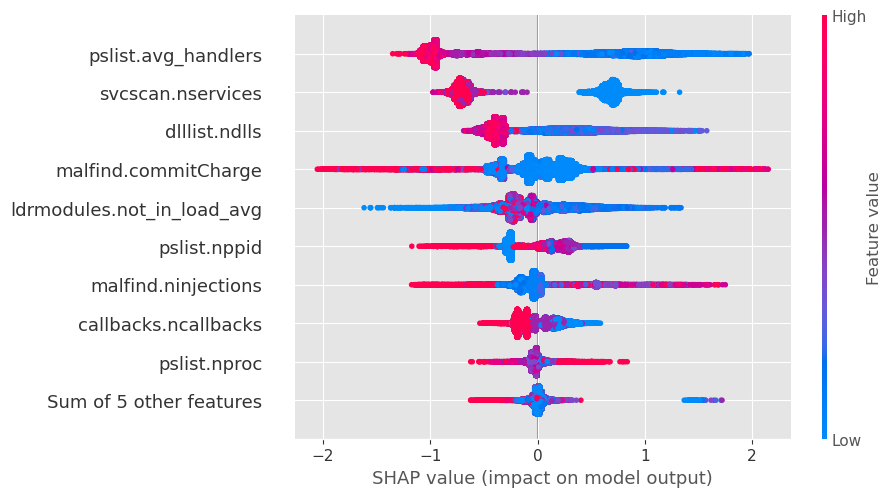

In [536]:
#Visualization of the mean SHAP values
shap.plots.bar(shap_values1[:, :,0])

shap.plots.beeswarm(shap_values1[:, :,3])

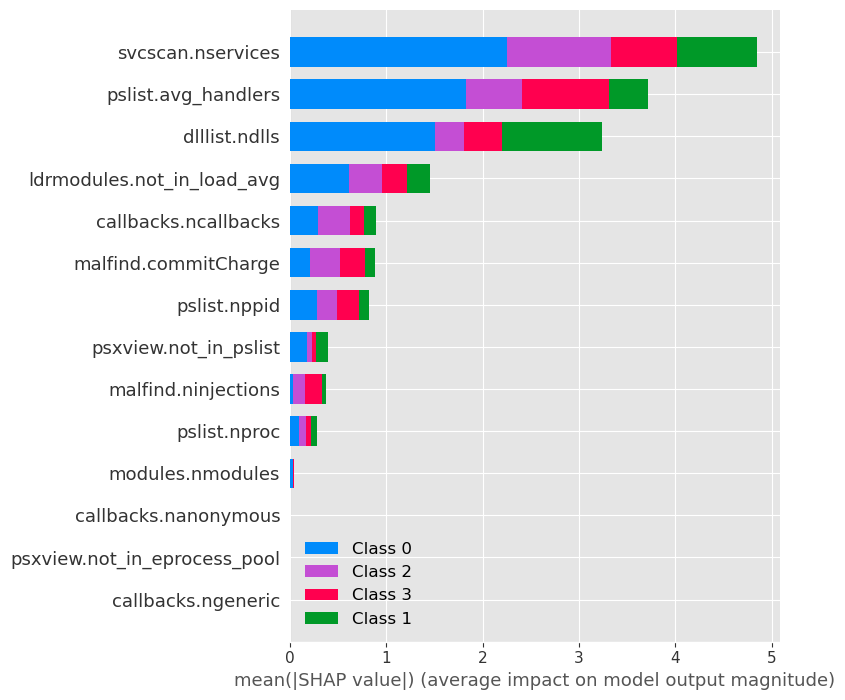

In [517]:
shap.summary_plot(
    [shap_values1[:, :, class_ind].values for class_ind in range(shap_values1.shape[-1])],
    feature_names=X1.columns,
    plot_type="bar"
)

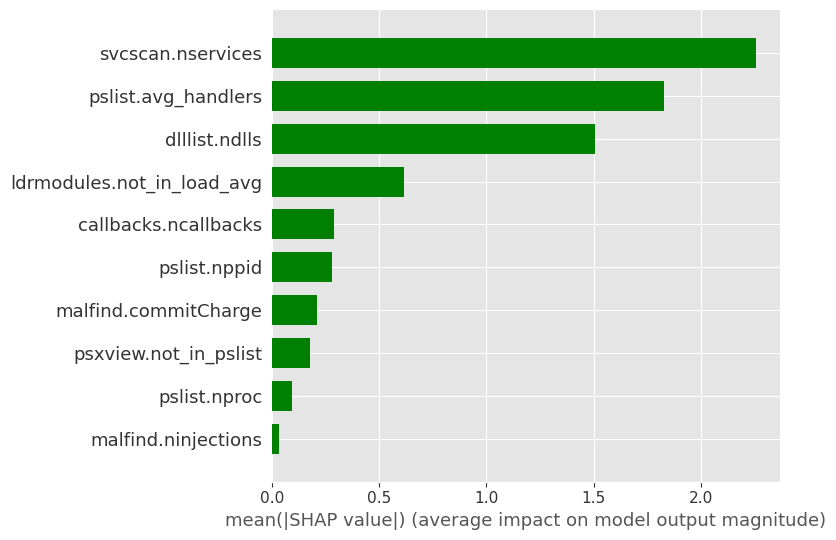

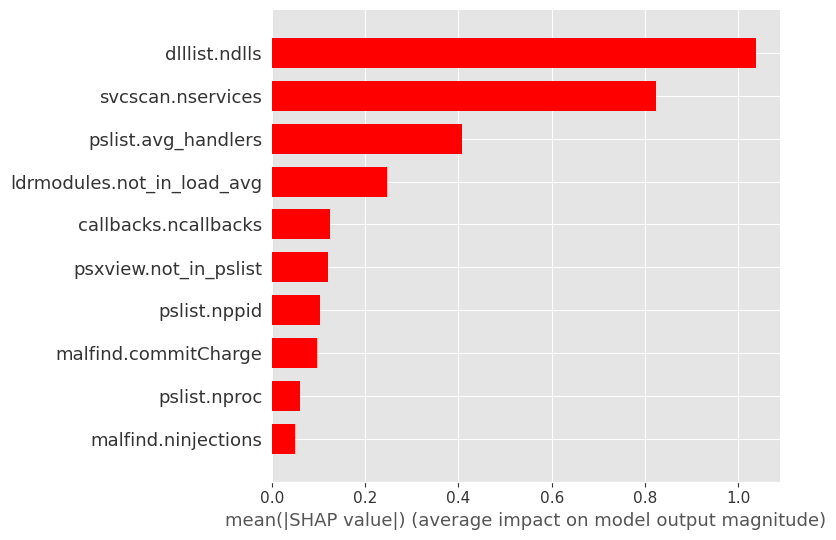

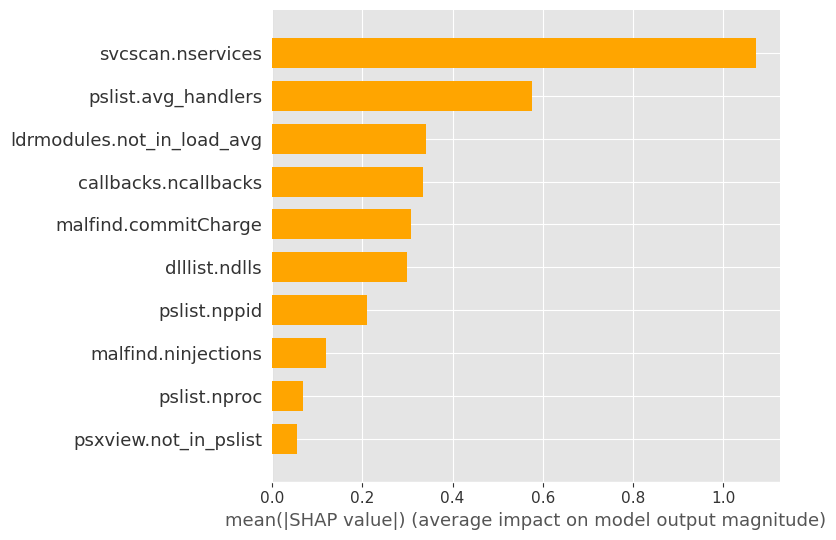

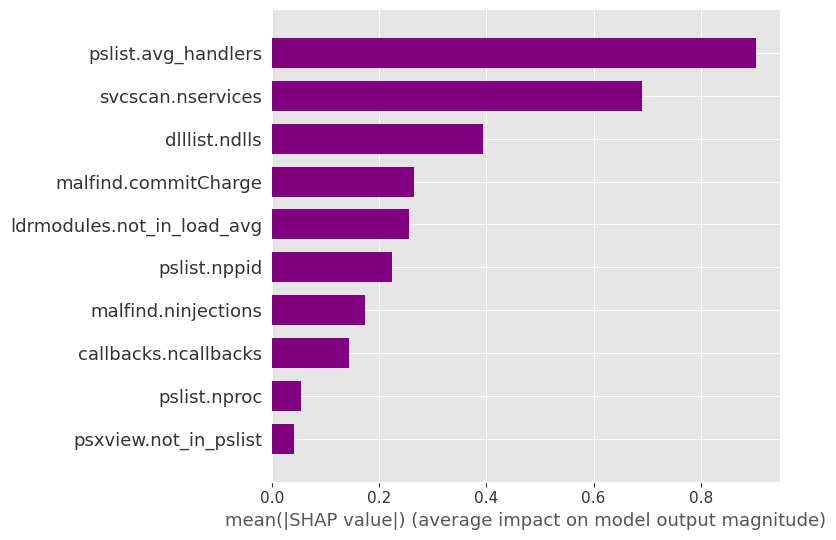

In [518]:
shap.summary_plot(
    shap_values1[:, :, 0],
    plot_type="bar", max_display= 10, color="green"
)
shap.summary_plot(
    shap_values1[:, :, 1],
    plot_type="bar", max_display= 10, color= "red"
)
shap.summary_plot(
    shap_values1[:, :, 2],
    plot_type="bar", max_display= 10, color= "orange"
)
shap.summary_plot(
    shap_values1[:, :, 3],
    plot_type="bar", max_display= 10, color= "purple"
)

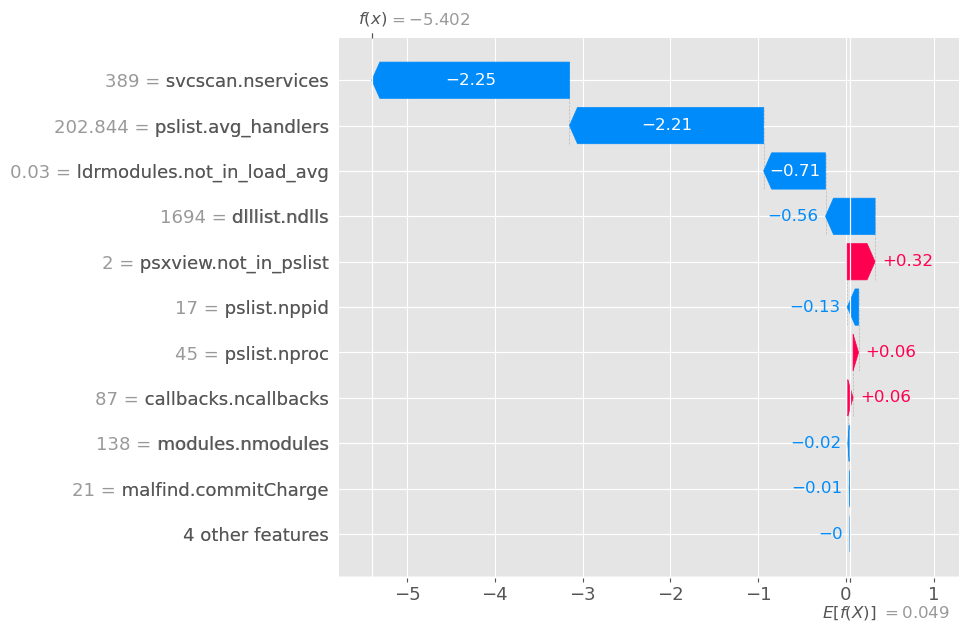

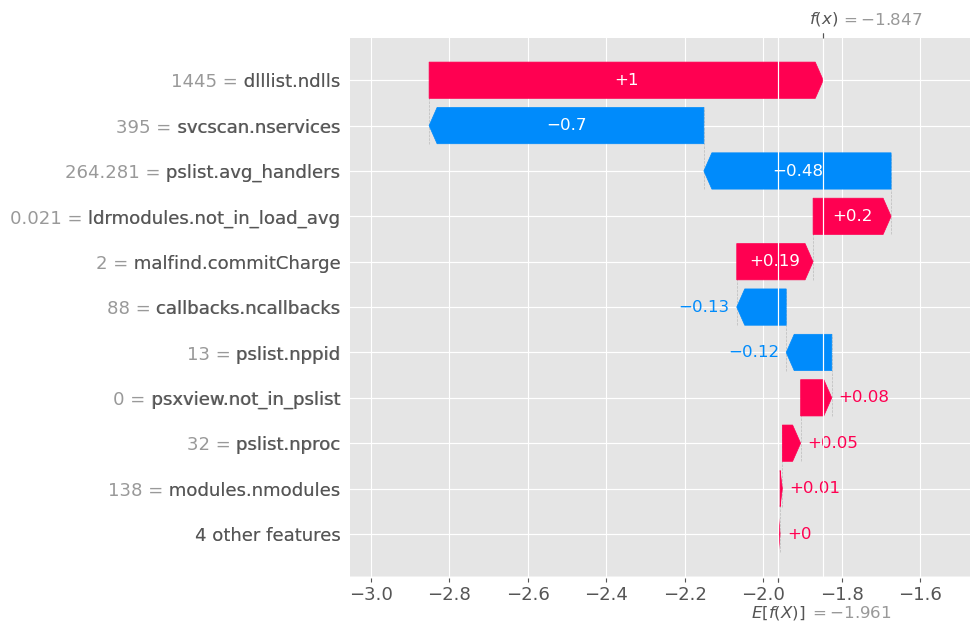

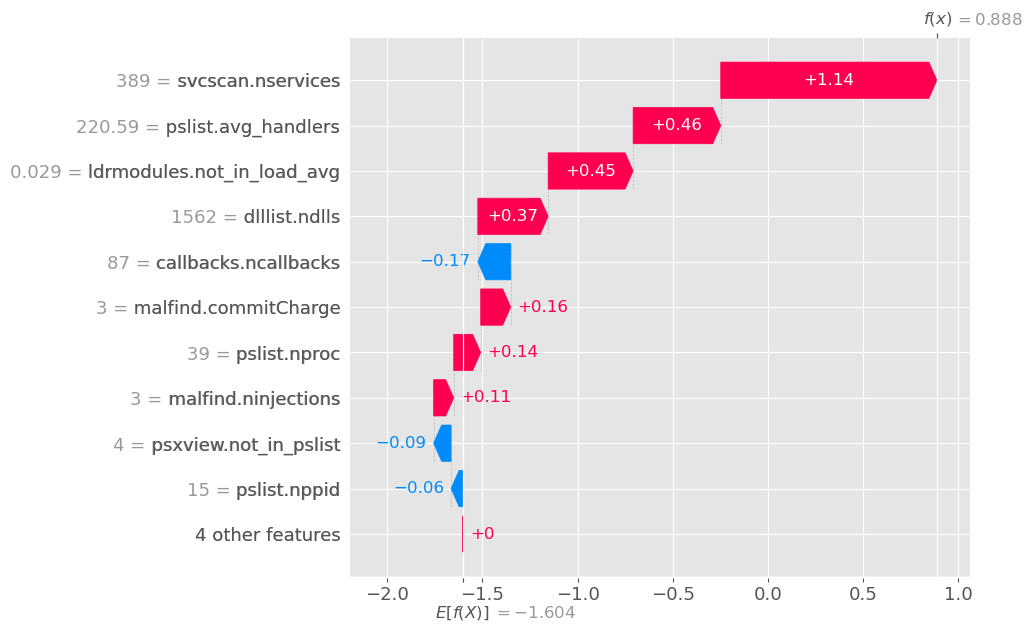

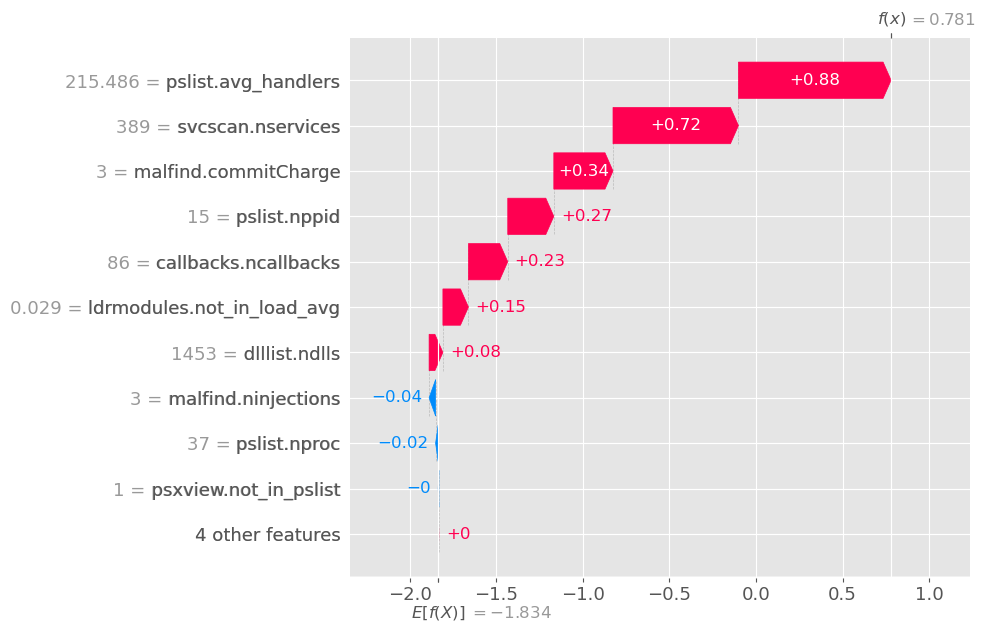

In [519]:
#Visualization of the SHAP values for each type of data(Trojan, Spyware, Ransomware and Benign)
shap.plots.waterfall(shap_values1[:, :, 0][0], max_display=11)
shap.plots.waterfall(shap_values1[:, :, 1][3], max_display=11)
shap.plots.waterfall(shap_values1[:, :, 2][29298], max_display=11)
shap.plots.waterfall(shap_values1[:, :, 3][58591], max_display=11)


### Reducing SHAP values to 2D

In [520]:
#0-Benign, 1-Ransomware, 2-Spyware, 3-Trojan
ShapBenign=shap_values1[:, :, 0].values
ShapRansomware=shap_values1[:, :, 1].values
ShapSpyware=shap_values1[:, :, 2].values
ShapTrojan=shap_values1[:, :, 3].values


ShapBenign =np.array(ShapBenign)
ShapBenign = pd.DataFrame(ShapBenign, columns= X1.columns)
ShapBenign["Class"]=dataset.Class
ShapBenign["Category"]=dataset.Category
ShapBenign["Family"]=dataset.Family
ShapBenign=ShapBenign[ShapBenign.Category=="Benign"]

ShapRansomware =np.array(ShapRansomware)
ShapRansomware = pd.DataFrame(ShapRansomware, columns= X1.columns)
ShapRansomware["Class"]=dataset.Class
ShapRansomware["Category"]=dataset.Category
ShapRansomware["Family"]=dataset.Family
ShapRansomware=ShapRansomware[ShapRansomware.Category=="Ransomware"]

ShapSpyware =np.array(ShapSpyware)
ShapSpyware = pd.DataFrame(ShapSpyware, columns= X1.columns)
ShapSpyware["Class"]=dataset.Class
ShapSpyware["Category"]=dataset.Category
ShapSpyware["Family"]=dataset.Family
ShapSpyware=ShapSpyware[ShapSpyware.Category=="Spyware"]

ShapTrojan =np.array(ShapTrojan)
ShapTrojan = pd.DataFrame(ShapTrojan, columns= X1.columns)
ShapTrojan["Class"]=dataset.Class
ShapTrojan["Category"]=dataset.Category
ShapTrojan["Family"]=dataset.Family
ShapTrojan=ShapTrojan[ShapTrojan.Category=="Trojan"]

dfs=[ShapBenign, ShapRansomware, ShapSpyware, ShapTrojan]

SHAPDataFrame= pd.concat(dfs)

In [151]:
len(shap_values1[:, :, 0])

58596

In [ ]:
#SHAPDataFrame.to_csv("C:\\Users\\rodri\\OneDrive\\Desktop\\tese\\Data\\SHAPDataFrame.csv",sep=",")

In [166]:
SHAPDataFrame

pslist.nproc  pslist.nppid  pslist.avg_threads  pslist.avg_handlers  \
0          0.003615      0.005274           -0.202837            -1.354998   
1          0.000000     -0.135675            0.039319             0.579768   
2          0.000000      0.053860            0.421176             1.559990   
3          0.000000      0.053860            0.078107             1.583112   
4          0.000000      0.005920            0.036029             1.007846   
...             ...           ...                 ...                  ...   
54891     -0.028711      0.187583            0.208778             0.504349   
54892     -0.024144      0.296892            0.126873             0.413664   
54893     -0.031213      0.221740            0.422809             0.111461   
54894     -0.030444      0.256303            0.917282             0.178840   
54895     -0.031294      0.258905            1.079148             0.190938   

       dlllist.ndlls  dlllist.avg_dlls_per_proc  handles.nhandles  \
0          -0.473271                  -0.699450          0.068484   
1           0.525237                   0.526160         -0.139556   
2           0.508040                   0.662934         -0.059477   
3           0.000000                   0.604784          0.000000   
4           0.634429                   0.540271         -0.119148   
...              ...                        ...               ...   
54891      -0.097540                   0.525742          0.171292   
54892      -0.028998                   0.442393          0.053474   
54893      -0.101841                   0.416590          0.083373   
54894       0.060379                   0.440874          0.095344   
54895       0.100074                   0.399194         -0.014156   

       handles.avg_handles_per_proc  handles.nfile  handles.nevent  \
0                         -6.501039      -0.005935        0.055441   
1                          2.230251      -0.039192        1.852939   
2                          5.336414       0.041384        1.538723   
3                          5.372950       0.037078       -0.213785   
4                          4.727261       0.029408        2.070296   
...                             ...            ...             ...   
54891                      1.229052       3.252384       -0.125320   
54892                      1.245891       3.195107       -0.198599   
54893                      1.125943       3.563164       -0.231843   
54894                      1.102012       3.482354       -0.282577   
54895                      1.094360       3.403594       -0.375721   

       handles.ndesktop  handles.nkey  handles.nthread  handles.ndirectory  \
0             -0.141790     -0.006458         0.189222           -0.196926   
1             -0.271715     -0.010014         1.249243           -0.035328   
2              0.000000      0.013974         1.192591            0.005996   
3              0.003143      0.001515         0.260175            0.003875   
4              0.000000      0.020625         0.878987            0.005467   
...                 ...           ...              ...                 ...   
54891          0.006975      1.101965         0.175250            0.113305   
54892         -0.003170      1.188174        -0.297313            0.078550   
54893         -0.010506      1.241905        -0.141558           -0.040160   
54894         -0.011873      1.114074        -0.104901           -0.007127   
54895          0.008454      0.975128        -0.156953           -0.004037   

       handles.nsemaphore  handles.ntimer  handles.nsection  handles.nmutant  \
0                0.015034       -0.126488         -0.190994        -0.058348   
1                0.072381        0.322745          0.043675         0.194935   
2               -0.104428        0.274859          0.235431         0.010586   
3               -0.105959        0.174544         -0.047595        -0.067103   
4                0.100389        0.225537          0.198957    

In [522]:
pcaShap1 = PCA(n_components=2)
ScalerShap1= StandardScaler()

In [523]:
SHAPDF1=SHAPDataFrame.drop(["Class", "Category", "Family"], axis=1)
SHAPDF1= ScalerShap1.fit_transform(SHAPDF1)
SHAP2D1=pcaShap1.fit_transform(SHAPDF1)

SHAP2D1 = np.array(SHAP2D1)
SHAPDF1= pd.DataFrame(SHAP2D1, columns=["Principal Component 1", "Principal Component 2"])

SHAPDF1["Class"]=SHAPDataFrame.Class
SHAPDF1["Category"]=SHAPDataFrame.Category
SHAPDF1["Family"]=SHAPDataFrame.Family


print(pcaShap1.explained_variance_ratio_*100)
SHAPDF1

[23.31356848 13.87439447]


Principal Component 1  Principal Component 2    Class    Category  \
0                   7.622042               0.464213   Benign      Benign   
1                  -0.570858               4.053365   Benign      Benign   
2                  -1.129764              -0.927975   Benign      Benign   
3                  -0.452405               0.379366   Benign      Benign   
4                  -1.545602               2.071619   Benign      Benign   
...                      ...                    ...      ...         ...   
58591               1.224525              -0.863032  Malware  Ransomware   
58592               1.626886              -1.410912  Malware  Ransomware   
58593               1.431808              -0.742756  Malware  Ransomware   
58594               1.477501              -0.463226  Malware  Ransomware   
58595               1.637591              -0.132298  Malware  Ransomware   

       Family  
0      Benign  
1      Benign  
2      Benign  
3      Benign  
4      Benign  
...       ...  
58591   Shade  
58592   Shade  
58593   Shade  
58594   Shade  
58595   Shade  

[58596 rows x 5 columns]

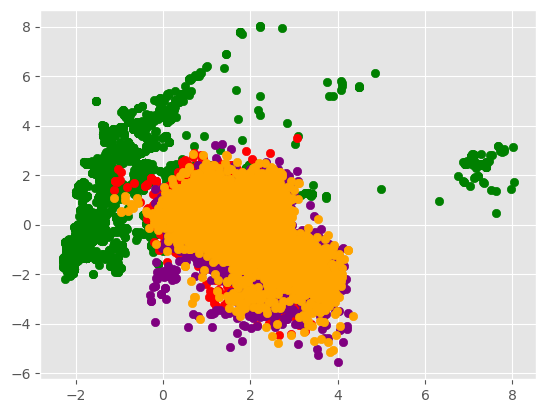

In [530]:
plt.scatter(SHAPDF1[SHAPDF1.Category=="Benign"]["Principal Component 1"],SHAPDF1[SHAPDF1.Category=="Benign"]["Principal Component 2"], color= "green", label= "Benign")
plt.scatter(SHAPDF1[SHAPDF1.Category=="Ransomware"]["Principal Component 1"],SHAPDF1[SHAPDF1.Category=="Ransomware"]["Principal Component 2"], color="red", label= "Ransomware")
plt.scatter(SHAPDF1[SHAPDF1.Category=="Trojan"]["Principal Component 1"],SHAPDF1[SHAPDF1.Category=="Trojan"]["Principal Component 2"], color= "purple", label= "Trojan")
plt.scatter(SHAPDF1[SHAPDF1.Category=="Spyware"]["Principal Component 1"],SHAPDF1[SHAPDF1.Category=="Spyware"]["Principal Component 2"], color= "orange", label= "Spyware")

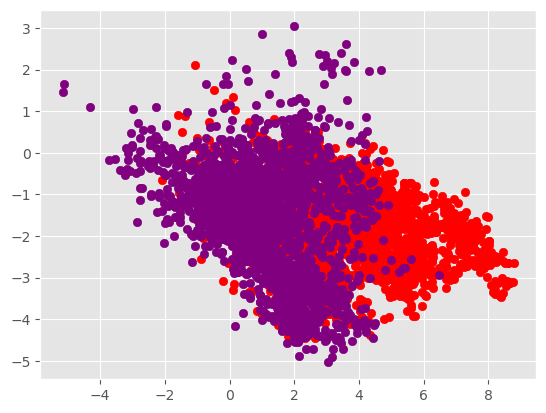

In [193]:
#plt.scatter(SHAPDF1[(SHAPDF1.Category=="Spyware")& (SHAPDF1.Family=="180solutions")]["Principal Component 1"],SHAPDF1[(SHAPDF1.Category=="Spyware") & (SHAPDF1.Family=="180solutions")]["Principal Component 2"], color= "orange", label= "Spyware")
plt.scatter(SHAPDF1[(SHAPDF1.Category=="Spyware")& (SHAPDF1.Family=="CWS")]["Principal Component 1"],SHAPDF1[(SHAPDF1.Category=="Spyware") & (SHAPDF1.Family=="CWS")]["Principal Component 2"], color= "red", label= "CWS")
plt.scatter(SHAPDF1[(SHAPDF1.Category=="Spyware")& (SHAPDF1.Family=="Gator")]["Principal Component 1"],SHAPDF1[(SHAPDF1.Category=="Spyware") & (SHAPDF1.Family=="Gator")]["Principal Component 2"], color= "purple", label= "Gator")
#plt.scatter(SHAPDF1[(SHAPDF1.Category=="Spyware")& (SHAPDF1.Family=="Transponder")]["Principal Component 1"],SHAPDF1[(SHAPDF1.Category=="Spyware") & (SHAPDF1.Family=="Transponder")]["Principal Component 2"], color= "blue", label= "Transponder")
#plt.scatter(SHAPDF1[(SHAPDF1.Category=="Spyware")& (SHAPDF1.Family=="TIBS")]["Principal Component 1"],SHAPDF1[(SHAPDF1.Category=="Spyware") & (SHAPDF1.Family=="TIBS")]["Principal Component 2"], color= "black", label= "TIBS")


In [178]:
SHAPDF1[SHAPDF1.Category=="Spyware"].Family.unique()

array(['180solutions', 'CWS', 'Gator', 'TIBS', 'Transponder'],
      dtype=object)

-----------------------------------------------

## Correlation

In [225]:
def correlation(dataset, threshold):
    col_corr=set()
    corr_matrix=dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname=corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr


In [230]:
corr_features=correlation(Corr, 0.7)

In [232]:
Corr.drop(corr_features, axis=1, inplace= True)

In [233]:
Corr

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0                45            17           202.844444           1694   
1                47            19           242.234043           2074   
2                40            14           288.225000           1932   
3                32            13           264.281250           1445   
4                42            16           281.333333           2067   
...             ...           ...                  ...            ...   
58591            37            15           215.486487           1453   
58592            37            14           190.216216           1347   
58593            38            15           210.026316           1448   
58594            37            15           215.513513           1452   
58595            38            15           213.026316           1487   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                        0.030372                    5                    21   
1                        0.036167                   12                    77   
2                        0.026114                    5                     6   
3                        0.021483                    2                     2   
4                        0.047820                   12                    77   
...                           ...                  ...                   ...   
58591                    0.029292                    3                     3   
58592                    0.030958                    3                     3   
58593                    0.029292                    3                     3   
58594                    0.029392                    3                     3   
58595                    0.029255                    3                     3   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                          2                             0               138   
1                          0                             0               138   
2                          0                             0               137   
3                          0                             0               138   
4                          4                             0               138   
...                      ...                           ...               ...   
58591                      1                             0               138   
58592                      0                             0               138   
58593                      2                             0               138   
58594                      0                             0               138   
58595                      3                             0               138   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0                    389                    87                     0   
1                    392                    87                     0   
2                    395                    88                     0   
3                    395                    88                     0   
4                    392                    87                     0   
...                  ...                   ...                   ...   
58591                389                    86                     0   
58592                389                    88                     0   
58593                389                    88                     0   
58594                389                    87                     0   
58595                389                    86                     0   

       callbacks.ngeneric  
0                       8  
1                       8  
2                       8  
3                       8  
4                       8  
...                   ...  
58591                   8  
58592                   8  
58593                   8  
58594                   8  
58595                   8  

[58596

In [234]:
CorrScaled= Scaler.fit_transform(Corr)

CorrScaled= np.array(CorrScaled)

CorrScaled= pd.DataFrame(datasetScaled,columns=Corr.columns)

CorrScaled

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0          0.624044      0.860519            -0.399308      -0.354192   
1          0.970233      1.613326            -0.047165       0.798092   
2         -0.241427     -0.268691             0.363994       0.367501   
3         -1.626181     -0.645094             0.149937      -1.109241   
4          0.104762      0.484116             0.302382       0.776865   
...             ...           ...                  ...            ...   
58591     -0.760710      0.107713            -0.286289      -1.084983   
58592     -0.760710     -0.268691            -0.512205      -1.406409   
58593     -0.587615      0.107713            -0.335102      -1.100144   
58594     -0.760710      0.107713            -0.286047      -1.088015   
58595     -0.587615      0.107713            -0.308282      -0.981884   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                       -0.301971            -0.130618             -0.156946   
1                        0.323590             0.324208             -0.147677   
2                       -0.761726            -0.130618             -0.159429   
3                       -1.261621            -0.325543             -0.160091   
4                        1.581546             0.324208             -0.147677   
...                           ...                  ...                   ...   
58591                   -0.418662            -0.260568             -0.159925   
58592                   -0.238815            -0.260568             -0.159925   
58593                   -0.418662            -0.260568             -0.159925   
58594                   -0.407855            -0.260568             -0.159925   
58595                   -0.422574            -0.260568             -0.159925   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                   0.041441                     -0.045677          0.194377   
1                  -0.626131                     -0.045677          0.194377   
2                  -0.626131                     -0.045677         -4.849775   
3                  -0.626131                     -0.045677          0.194377   
4                   0.709014                     -0.045677          0.194377   
...                      ...                           ...               ...   
58591              -0.292345                     -0.045677          0.194377   
58592              -0.626131                     -0.045677          0.194377   
58593               0.041441                     -0.045677          0.194377   
58594              -0.626131                     -0.045677          0.194377   
58595               0.375228                     -0.045677          0.194377   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0              -0.518261              0.030102             -0.029224   
1               0.144039              0.030102             -0.029224   
2               0.806340              0.349173             -0.029224   
3               0.806340              0.349173             -0.029224   
4               0.144039              0.030102             -0.029224   
...                  ...                   ...                   ...   
58591          -0.518261             -0.288970             -0.029224   
58592          -0.518261              0.349173             -0.029224   
58593          -0.518261              0.349173             -0.029224   
58594          -0.518261              0.030102             -0.029224   
58595          -0.518261             -0.288970             -0.029224   

       callbacks.ngeneric  
0                0.010931  
1                0.010931  
2                0.010931  
3                0.010931  
4                0.010931  
...                   ...  
58591            0.010931  
58592            0.010931  
58593            0.010931  
58594            0.010931  
58595            0.010931  

[58596

In [235]:
CorrScaled[["Principal Component 1", "Principal Component 2"]]= pca.fit_transform(CorrScaled)
print(pca.explained_variance_ratio_*100)
CorrScaled= CorrScaled[["Principal Component 1", "Principal Component 2"]]

[16.91366026 15.155672  ]


In [239]:
CorrScaled["Category"]= dataset["Category"]
CorrScaled["Class"]= dataset["Class"]
CorrScaled["Family"]= dataset["Family"]
CorrScaled


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Principal Component 1  Principal Component 2    Category    Class  \
0                  -0.591472               0.663037      Benign   Benign   
1                   0.484213               1.571208      Benign   Benign   
2                  -0.381023              -2.177216      Benign   Benign   
3                  -0.124257              -2.059165      Benign   Benign   
4                   0.572765               1.039119      Benign   Benign   
...                      ...                    ...         ...      ...   
58591              -1.077399              -0.727983  Ransomware  Malware   
58592              -0.989608              -1.137507  Ransomware  Malware   
58593              -0.959397              -0.682404  Ransomware  Malware   
58594              -0.939288              -0.860482  Ransomware  Malware   
58595              -1.106866              -0.461532  Ransomware  Malware   

       Family  
0      Benign  
1      Benign  
2      Benign  
3      Benign  
4      Benign  
...       ...  
58591   Shade  
58592   Shade  
58593   Shade  
58594   Shade  
58595   Shade  

[58596 rows x 5 columns]

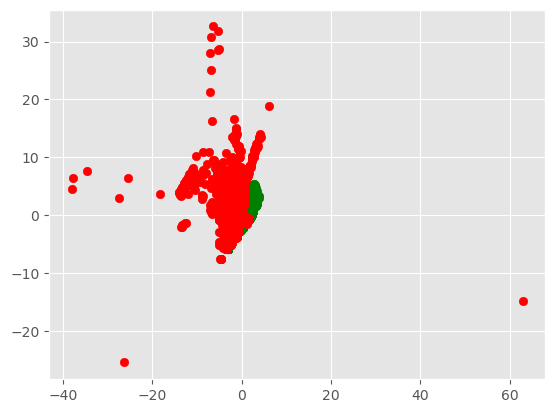

In [245]:
plt.scatter(CorrScaled[CorrScaled.Category=="Benign"]["Principal Component 1"],CorrScaled[CorrScaled.Category=="Benign"]["Principal Component 2"], color= "green")
plt.scatter(CorrScaled[CorrScaled.Class=="Malware"]["Principal Component 1"],CorrScaled[CorrScaled.Class=="Malware"]["Principal Component 2"], color= "red")

In [278]:
CorrPredict=KmeansTest.fit_predict(CorrScaled[["Principal Component 1", "Principal Component 2"]])

In [279]:
CorrScaled["Cluster"]= CorrPredict


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


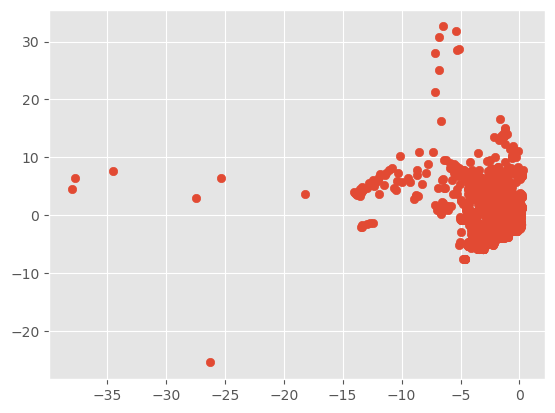

In [288]:
plt.scatter(CorrScaled[CorrScaled.Cluster==0]["Principal Component 1"],CorrScaled[CorrScaled.Cluster==0]["Principal Component 2"])
plt.scatter(CorrScaled[CorrScaled.Cluster==1]["Principal Component 1"],CorrScaled[CorrScaled.Cluster==1]["Principal Component 2"])
#0 malware | 1 benign

In [289]:
count= 0
for i in range(len(CorrScaled)):
    if (CorrScaled["Cluster"][i]== 0 and CorrScaled["Class"][i]== "Malware") or (CorrScaled["Cluster"][i]== 1 and CorrScaled["Class"][i]== "Benign"):
        count += 1
        
print("Accuracy:", count/len(CorrScaled)*100, "%")

#false positive rate
print("False Positive rate:", len(CorrScaled[CorrScaled.Cluster==1][CorrScaled.Class== "Malware"])/(len(CorrScaled[CorrScaled.Cluster==1][CorrScaled.Class== "Malware"])+len(CorrScaled[CorrScaled.Cluster==0][CorrScaled.Class=="Malware"])) * 100, "%")


Accuracy: 93.2845245409243 %
False Positive rate: 0.6246160147450338 %


Boolean Series key will be reindexed to match DataFrame index.


In [251]:
Class = ["Benign", "Malware"]
Category=['Benign', 'Ransomware', 'Spyware', 'Trojan']
Family= ['Benign', 'Ako', 'Conti', 'Maze', 'Pysa', 'Shade', '180solutions',
       'CWS', 'Gator', 'TIBS', 'Transponder', 'Emotet', 'Reconyc',
       'Refroso', 'Scar', 'Zeus']

Code1=[0,1]
Code2=[0,1,2,3]
Code3=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]


Corr["Class"]= dataset.Class
Corr["Category"]= dataset.Category
Corr["Family"]= dataset.Family


Corr.Class.replace(Class, Code1, inplace= True)
Corr.Category.replace(Category, Code2, inplace= True)
Corr.Family.replace(Family, Code3, inplace= True)
#dropping useless futures
Corr

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0                45            17           202.844444           1694   
1                47            19           242.234043           2074   
2                40            14           288.225000           1932   
3                32            13           264.281250           1445   
4                42            16           281.333333           2067   
...             ...           ...                  ...            ...   
58591            37            15           215.486487           1453   
58592            37            14           190.216216           1347   
58593            38            15           210.026316           1448   
58594            37            15           215.513513           1452   
58595            38            15           213.026316           1487   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                        0.030372                    5                    21   
1                        0.036167                   12                    77   
2                        0.026114                    5                     6   
3                        0.021483                    2                     2   
4                        0.047820                   12                    77   
...                           ...                  ...                   ...   
58591                    0.029292                    3                     3   
58592                    0.030958                    3                     3   
58593                    0.029292                    3                     3   
58594                    0.029392                    3                     3   
58595                    0.029255                    3                     3   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                          2                             0               138   
1                          0                             0               138   
2                          0                             0               137   
3                          0                             0               138   
4                          4                             0               138   
...                      ...                           ...               ...   
58591                      1                             0               138   
58592                      0                             0               138   
58593                      2                             0               138   
58594                      0                             0               138   
58595                      3                             0               138   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0                    389                    87                     0   
1                    392                    87                     0   
2                    395                    88                     0   
3                    395                    88                     0   
4                    392                    87                     0   
...                  ...                   ...                   ...   
58591                389                    86                     0   
58592                389                    88                     0   
58593                389                    88                     0   
58594                389                    87                     0   
58595                389                    86                     0   

       callbacks.ngeneric  Class  Category  Family  
0                       8      0         0       0  
1                       8      0         0       0  
2                       8      0         0       0  
3                       8      0         0       0  
4                       8      0         0       0  
...                   ...

In [252]:
ClassifierTeste= xgb.XGBClassifier()

In [253]:
XTeste = Corr.drop(["Category","Class","Family"], axis=1)
YTeste = Corr["Class"]

xteste_train,xteste_test, yteste_train,yteste_test= train_test_split(XTeste, YTeste, test_size=0.2, random_state=0)

In [259]:
yteste_train

53120    1
56385    1
55469    1
29788    1
18509    0
        ..
45891    1
52416    1
42613    1
43567    1
2732     0
Name: Class, Length: 46876, dtype: int64

In [260]:
ClassifierTeste.fit(xteste_train,yteste_train,eval_set=[(xteste_test, yteste_test)])

[0]	validation_0-logloss:0.43805
[1]	validation_0-logloss:0.29712
[2]	validation_0-logloss:0.20834
[3]	validation_0-logloss:0.14893
[4]	validation_0-logloss:0.10785
[5]	validation_0-logloss:0.07885
[6]	validation_0-logloss:0.05779
[7]	validation_0-logloss:0.04249
[8]	validation_0-logloss:0.03143
[9]	validation_0-logloss:0.02334
[10]	validation_0-logloss:0.01742
[11]	validation_0-logloss:0.01306
[12]	validation_0-logloss:0.00988
[13]	validation_0-logloss:0.00750
[14]	validation_0-logloss:0.00575
[15]	validation_0-logloss:0.00446
[16]	validation_0-logloss:0.00352
[17]	validation_0-logloss:0.00283
[18]	validation_0-logloss:0.00232
[19]	validation_0-logloss:0.00194
[20]	validation_0-logloss:0.00167
[21]	validation_0-logloss:0.00148
[22]	validation_0-logloss:0.00135
[23]	validation_0-logloss:0.00125
[24]	validation_0-logloss:0.00114
[25]	validation_0-logloss:0.00110
[26]	validation_0-logloss:0.00103
[27]	validation_0-logloss:0.00100
[28]	validation_0-logloss:0.00093
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [261]:
start_time=timer(None)
explainerTeste = shap.TreeExplainer(ClassifierTeste, XTeste)
shap_valuesTeste= explainerTeste(XTeste)
timer(start_time)

 99%|===================| 58188/58596 [00:46<00:00]        


 Time taken: 0 hours 0 minutes and 45 seconds.


In [263]:
SHAPDFTeste= ScalerShap.fit_transform(shap_valuesTeste.values)
SHAP2DTeste=pcaShap.fit_transform(SHAPDFTeste)

SHAP2DTeste = np.array(SHAP2DTeste)
SHAPDFTeste= pd.DataFrame(SHAP2DTeste, columns=["Principal Component 1", "Principal Component 2"])

print(pcaShap.explained_variance_ratio_*100)
SHAPDFTeste

[40.60865928 16.88962328]


Principal Component 1  Principal Component 2
0                  -0.993153               2.810165
1                   1.830041               4.235095
2                   1.663534              -1.383809
3                   0.386040              -1.573242
4                   1.694215               1.376677
...                      ...                    ...
58591              -2.288191              -1.181899
58592              -2.195146              -0.915991
58593              -2.450155              -0.297677
58594              -2.263223              -0.528827
58595              -2.563825              -0.857965

[58596 rows x 2 columns]

In [264]:
SHAPDFTeste["Category"]= dataset["Category"]
SHAPDFTeste["Class"]= dataset["Class"]
SHAPDFTeste["Family"]= dataset["Family"]
SHAPDFTeste

Principal Component 1  Principal Component 2    Category    Class  \
0                  -0.993153               2.810165      Benign   Benign   
1                   1.830041               4.235095      Benign   Benign   
2                   1.663534              -1.383809      Benign   Benign   
3                   0.386040              -1.573242      Benign   Benign   
4                   1.694215               1.376677      Benign   Benign   
...                      ...                    ...         ...      ...   
58591              -2.288191              -1.181899  Ransomware  Malware   
58592              -2.195146              -0.915991  Ransomware  Malware   
58593              -2.450155              -0.297677  Ransomware  Malware   
58594              -2.263223              -0.528827  Ransomware  Malware   
58595              -2.563825              -0.857965  Ransomware  Malware   

       Family  
0      Benign  
1      Benign  
2      Benign  
3      Benign  
4      Benign  
...       ...  
58591   Shade  
58592   Shade  
58593   Shade  
58594   Shade  
58595   Shade  

[58596 rows x 5 columns]

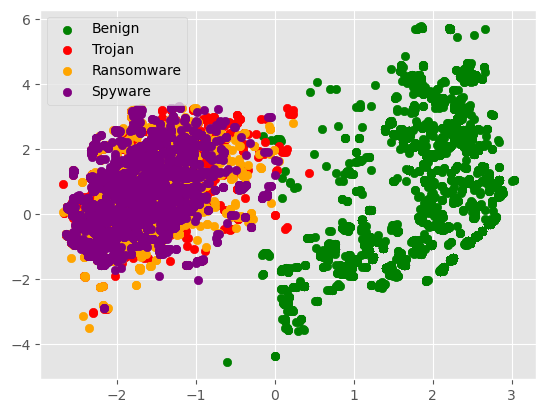

In [266]:

plt.scatter(SHAPDFTeste[SHAPDFTeste.Category=="Benign"]["Principal Component 1"], SHAPDFTeste[SHAPDFTeste.Category=="Benign"]["Principal Component 2"], color= "green", label= "Benign")
plt.scatter(SHAPDFTeste[SHAPDFTeste.Category=="Trojan"]["Principal Component 1"], SHAPDFTeste[SHAPDFTeste.Category=="Trojan"]["Principal Component 2"], color= "red", label= "Trojan")
plt.scatter(SHAPDFTeste[SHAPDFTeste.Category=="Ransomware"]["Principal Component 1"], SHAPDFTeste[SHAPDFTeste.Category=="Ransomware"]["Principal Component 2"], color= "orange", label= "Ransomware")
plt.scatter(SHAPDFTeste[SHAPDFTeste.Category=="Spyware"]["Principal Component 1"], SHAPDFTeste[SHAPDFTeste.Category=="Spyware"]["Principal Component 2"], color= "purple", label= "Spyware")
plt.legend()

In [268]:
KmeansTest=KMeans(n_clusters=2, random_state=1)

In [269]:
yTeste_pred=KmeansTest.fit_predict(SHAPDFTeste[["Principal Component 1", "Principal Component 2"]])

In [271]:
SHAPDFTeste["Cluster"]= yTeste_pred

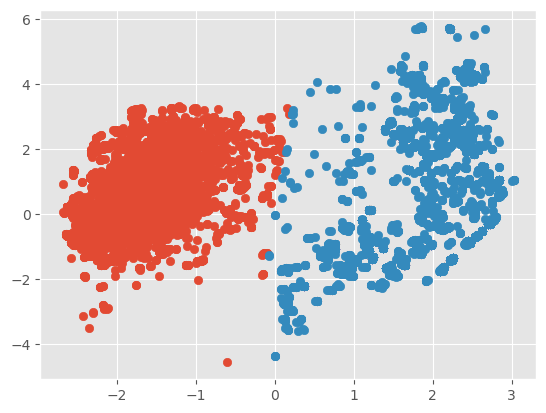

In [276]:
plt.scatter(SHAPDFTeste[SHAPDFTeste.Cluster==0]["Principal Component 1"],SHAPDFTeste[SHAPDFTeste.Cluster==0]["Principal Component 2"])
plt.scatter(SHAPDFTeste[SHAPDFTeste.Cluster==1]["Principal Component 1"],SHAPDFTeste[SHAPDFTeste.Cluster==1]["Principal Component 2"])
#0 malware | 1 benign

In [300]:
def accuracy0Malware(dataset):
    count= 0
    for i in range(len(dataset)):
        if (dataset["Cluster"][i]== 0 and dataset["Class"][i]== "Malware") or (dataset["Cluster"][i]== 1 and dataset["Class"][i]== "Benign"):
            count += 1
        
    return print("Accuracy:", count/len(dataset)*100, "% \n False Positive rate:", len(dataset[dataset.Cluster==1][dataset.Class== "Malware"])/(len(dataset[dataset.Cluster==1][dataset.Class== "Malware"])+len(dataset[SHAPDFTeste.Cluster==0][dataset.Class=="Malware"])) * 100, "%") 

def accuracy0Benign(dataset):
    count= 0
    for i in range(len(dataset)):
        if (dataset["Cluster"][i]== 1 and dataset["Class"][i]== "Malware") or (dataset["Cluster"][i]== 0 and dataset["Class"][i]== "Benign"):
            count += 1
        
    return print("Accuracy:", count/len(dataset)*100, "% \n False Positive rate:", len(dataset[dataset.Cluster==0][dataset.Class== "Malware"])/(len(dataset[dataset.Cluster==0][dataset.Class== "Malware"])+len(dataset[SHAPDFTeste.Cluster==1][dataset.Class=="Malware"])) * 100, "%") 

#false positive rate
#print("False Positive rate:", len(SHAPDFTeste[SHAPDFTeste.Cluster==1][SHAPDFTeste.Class== "Malware"])/(len(SHAPDFTeste[SHAPDFTeste.Cluster==1][SHAPDFTeste.Class== "Malware"])+len(SHAPDFTeste[SHAPDFTeste.Cluster==0][SHAPDFTeste.Class=="Malware"])) * 100, "%")


Accuracy: 0.07338384872687555 % 
 False Positive rate: 99.95221516827087 %


Boolean Series key will be reindexed to match DataFrame index.


In [695]:
#0 malware | 1 benign
accuracy0Malware(SHAPDFTeste)

Accuracy: 99.92661615127312 % 
 False Positive rate: 0.047784831729128265 %


Boolean Series key will be reindexed to match DataFrame index.


In [221]:
Corr=dataset2.drop(["Category","Class", "Family"], axis=1)

In [313]:
dataset

Category  pslist.nproc  pslist.nppid  pslist.avg_threads  \
0          Benign            45            17           10.555556   
1          Benign            47            19           11.531915   
2          Benign            40            14           14.725000   
3          Benign            32            13           13.500000   
4          Benign            42            16           11.452381   
...           ...           ...           ...                 ...   
58591  Ransomware            37            15           10.108108   
58592  Ransomware            37            14            9.945946   
58593  Ransomware            38            15            9.842105   
58594  Ransomware            37            15           10.243243   
58595  Ransomware            38            15            9.868421   

       pslist.nprocs64bit  pslist.avg_handlers  dlllist.ndlls  \
0                       0           202.844444           1694   
1                       0           242.234043           2074   
2                       0           288.225000           1932   
3                       0           264.281250           1445   
4                       0           281.333333           2067   
...                   ...                  ...            ...   
58591                   0           215.486487           1453   
58592                   0           190.216216           1347   
58593                   0           210.026316           1448   
58594                   0           215.513513           1452   
58595                   0           213.026316           1487   

       dlllist.avg_dlls_per_proc  handles.nhandles  \
0                      38.500000              9129   
1                      44.127660             11385   
2                      48.300000             11529   
3                      45.156250              8457   
4                      49.214286             11816   
...                          ...               ...   
58591                  39.270270              7973   
58592                  36.405405              7038   
58593                  38.105263              7982   
58594                  39.243243              7974   
58595                  39.131579              8095   

       handles.avg_handles_per_proc  handles.nport  handles.nfile  \
0                        212.302326              0            670   
1                        242.234043              0            840   
2                        288.225000              0           1050   
3                        264.281250              0            630   
4                        281.333333              0            908   
...                             ...            ...            ...   
58591                    215.486487              0            630   
58592                    190.216216              0            603   
58593                    215.729730              0            624   
58594                    215.513513              0            632   
58595                    213.026316              0            637   

       handles.nevent  handles.ndesktop  handles.nkey  handles.nthread  \
0                3161                46           716              887   
1                3761                51          1011             1030   
2                3996                45           784             1241   
3                2961                36           654              792   
4                3834                45          1252              942   
...               ...               ...           ...              ...   
58591            2819                40           668              664   
58592            2394                39           555              624   
58593            2816                40           673              661   
58594            2819                40           668              667   
58595            2843                41           683              669   

       handles.ndirectory  handl

In [222]:
corrmat=Corr.corr()

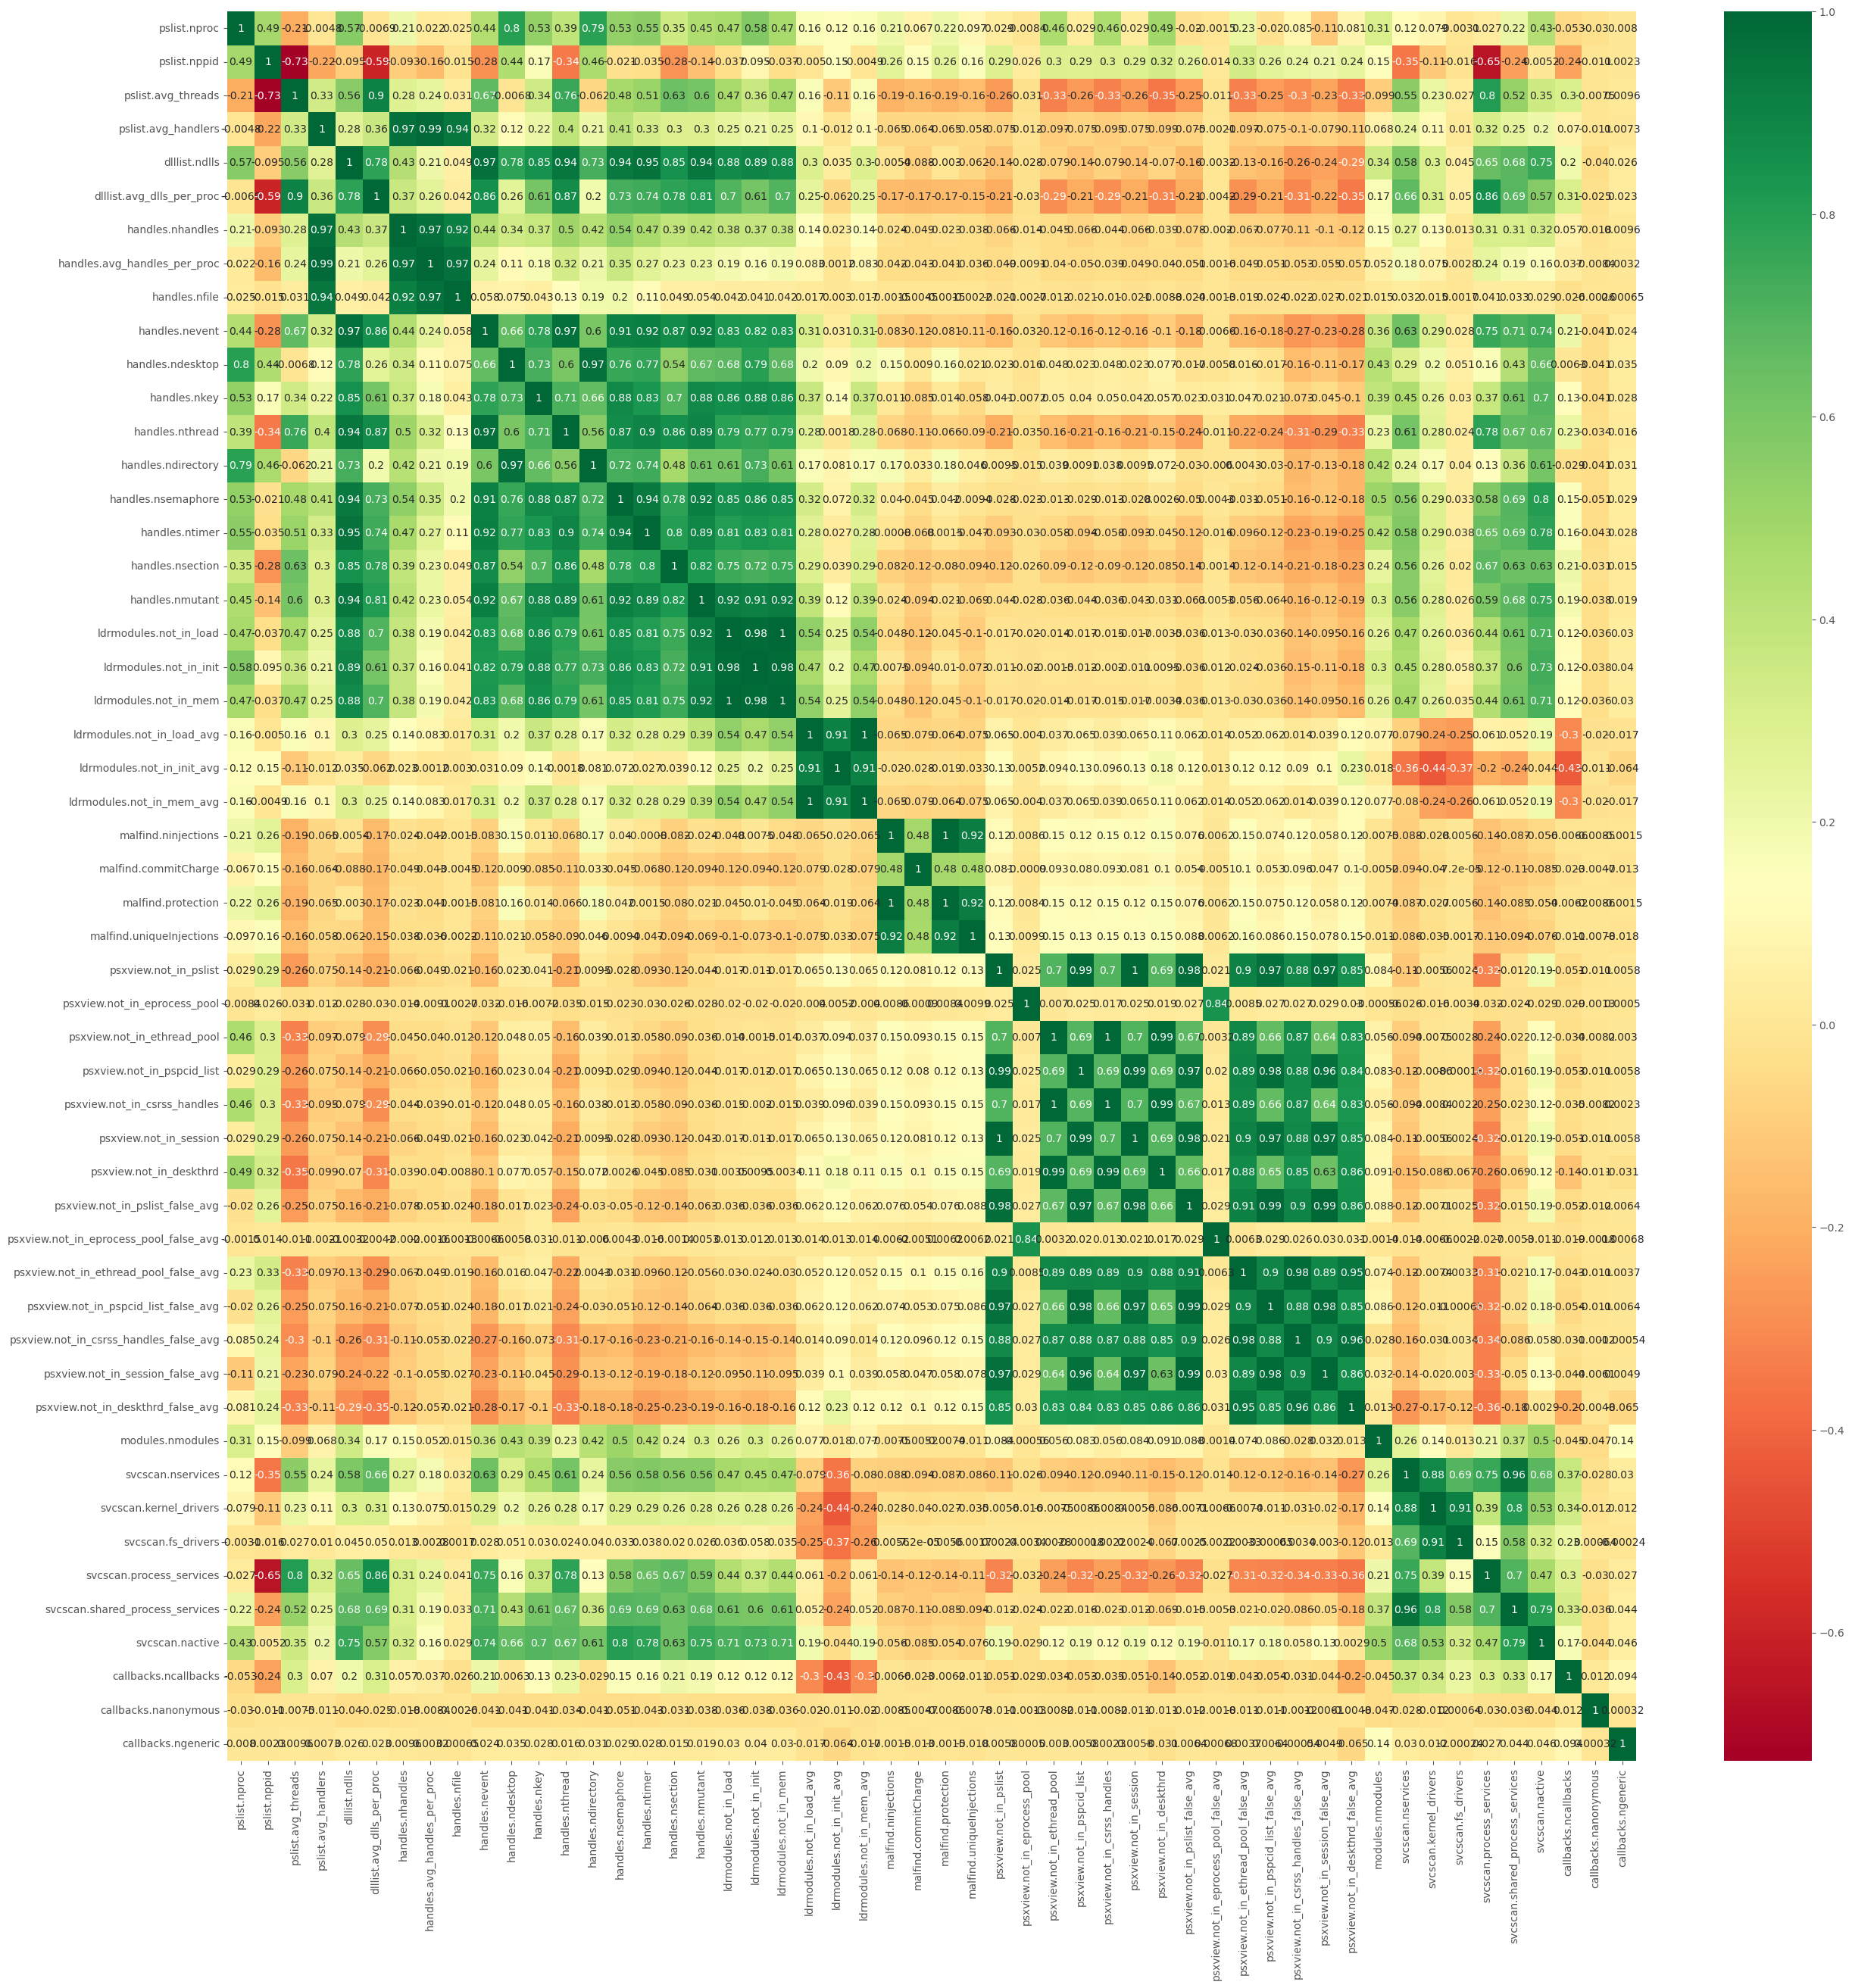

In [223]:
top_corr_feats=corrmat.index
plt.figure(figsize=(30,30))
g= sns.heatmap(dataset2[top_corr_feats].corr(), annot=True, cmap="RdYlGn")

In [687]:
dataset2

Category  pslist.nproc  pslist.nppid  pslist.avg_handlers  \
0             0            45            17           202.844444   
1             0            47            19           242.234043   
2             0            40            14           288.225000   
3             0            32            13           264.281250   
4             0            42            16           281.333333   
...         ...           ...           ...                  ...   
58591         1            37            15           215.486487   
58592         1            37            14           190.216216   
58593         1            38            15           210.026316   
58594         1            37            15           215.513513   
58595         1            38            15           213.026316   

       dlllist.ndlls  ldrmodules.not_in_load_avg  malfind.ninjections  \
0               1694                    0.030372                    5   
1               2074                    0.036167                   12   
2               1932                    0.026114                    5   
3               1445                    0.021483                    2   
4               2067                    0.047820                   12   
...              ...                         ...                  ...   
58591           1453                    0.029292                    3   
58592           1347                    0.030958                    3   
58593           1448                    0.029292                    3   
58594           1452                    0.029392                    3   
58595           1487                    0.029255                    3   

       malfind.commitCharge  psxview.not_in_pslist  \
0                        21                      2   
1                        77                      0   
2                         6                      0   
3                         2                      0   
4                        77                      4   
...                     ...                    ...   
58591                     3                      1   
58592                     3                      0   
58593                     3                      2   
58594                     3                      0   
58595                     3                      3   

       psxview.not_in_eprocess_pool  modules.nmodules  svcscan.nservices  \
0                                 0               138                389   
1                                 0               138                392   
2                                 0               137                395   
3                                 0               138                395   
4                                 0               138                392   
...                             ...               ...                ...   
58591                             0               138                389   
58592                             0               138                389   
58593                             0               138                389   
58594                             0               138                389   
58595                             0               138                389   

       callbacks.ncallbacks  callbacks.nanonymous  callbacks.ngeneric  Class  \
0                        87                     0                   8      0   
1                        87                     0                   8      0   
2                        88                     0                   8      0   
3                        88                     0                   8      0   
4                        87                     0                   8      0   
...                     ...                   ...                 ...    ...   
58591                    86                     0                   8      1   
58592                    88                     0                   8      1   
58593                    88    

In [688]:
dataset

Category  pslist.nproc  pslist.nppid  pslist.avg_threads  \
0          Benign            45            17           10.555556   
1          Benign            47            19           11.531915   
2          Benign            40            14           14.725000   
3          Benign            32            13           13.500000   
4          Benign            42            16           11.452381   
...           ...           ...           ...                 ...   
58591  Ransomware            37            15           10.108108   
58592  Ransomware            37            14            9.945946   
58593  Ransomware            38            15            9.842105   
58594  Ransomware            37            15           10.243243   
58595  Ransomware            38            15            9.868421   

       pslist.avg_handlers  dlllist.ndlls  dlllist.avg_dlls_per_proc  \
0               202.844444           1694                  38.500000   
1               242.234043           2074                  44.127660   
2               288.225000           1932                  48.300000   
3               264.281250           1445                  45.156250   
4               281.333333           2067                  49.214286   
...                    ...            ...                        ...   
58591           215.486487           1453                  39.270270   
58592           190.216216           1347                  36.405405   
58593           210.026316           1448                  38.105263   
58594           215.513513           1452                  39.243243   
58595           213.026316           1487                  39.131579   

       handles.nhandles  handles.avg_handles_per_proc  handles.nfile  \
0                  9129                    212.302326            670   
1                 11385                    242.234043            840   
2                 11529                    288.225000           1050   
3                  8457                    264.281250            630   
4                 11816                    281.333333            908   
...                 ...                           ...            ...   
58591              7973                    215.486487            630   
58592              7038                    190.216216            603   
58593              7982                    215.729730            624   
58594              7974                    215.513513            632   
58595              8095                    213.026316            637   

       handles.nevent  handles.ndesktop  handles.nkey  handles.nthread  \
0                3161                46           716              887   
1                3761                51          1011             1030   
2                3996                45           784             1241   
3                2961                36           654              792   
4                3834                45          1252              942   
...               ...               ...           ...              ...   
58591            2819                40           668              664   
58592            2394                39           555              624   
58593            2816                40           673              661   
58594            2819                40           668              667   
58595            2843                41           683              669   

       handles.ndirectory  handles.nsemaphore  handles.ntimer  \
0                     104                 671             125   
1                     117                 766             148   
2                     100                 645             138   
3                      83                 567             127   
4                     103                 825             135   
...                   ...                 ...             ...   
58591                  92                 596             113   
58592                  91                

### testes

In [601]:
dataset3= dataset2[dataset2.Class !=0]
New=[0,1,2]
old=[1,2,3]
dataset3.replace(old, New, inplace=True)
X2 = dataset3.drop(["Category","Class","Family"], axis=1)
Y2 = dataset3["Category"]

x2_train,x2_test, y2_train,y2_test= train_test_split(X2, Y2, test_size=0.2, random_state=0)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [602]:
dataset3

Category  pslist.nproc  pslist.nppid  pslist.avg_handlers  \
29298         0            39            15           220.589744   
29299         0            37            15           214.648649   
29300         0            39            15           217.410256   
29301         0            41            16           210.170732   
29302         0            40            16           208.650000   
...         ...           ...           ...                  ...   
58591         0            37            15           215.486487   
58592         0            37            14           190.216216   
58593         0            38            15           210.026316   
58594         0            37            15           215.513513   
58595         0            38            15           213.026316   

       dlllist.ndlls  ldrmodules.not_in_load_avg  malfind.ninjections  \
29298           1562                    0.029229                    2   
29299           1445                    0.028826                    2   
29300           1551                    0.029430                    2   
29301           1614                    0.027728                    2   
29302           1556                    0.028160                    2   
...              ...                         ...                  ...   
58591           1453                    0.029292                    2   
58592           1347                    0.030958                    2   
58593           1448                    0.029292                    2   
58594           1452                    0.029392                    2   
58595           1487                    0.029255                    2   

       malfind.commitCharge  psxview.not_in_pslist  \
29298                     2                      4   
29299                     2                      0   
29300                     2                      4   
29301                     2                      4   
29302                     2                      5   
...                     ...                    ...   
58591                     2                      0   
58592                     2                      0   
58593                     2                      1   
58594                     2                      0   
58595                     2                      2   

       psxview.not_in_eprocess_pool  modules.nmodules  svcscan.nservices  \
29298                             0               138                389   
29299                             0               138                389   
29300                             0               138                389   
29301                             0               138                389   
29302                             0               138                389   
...                             ...               ...                ...   
58591                             0               138                389   
58592                             0               138                389   
58593                             0               138                389   
58594                             0               138                389   
58595                             0               138                389   

       callbacks.ncallbacks  callbacks.nanonymous  callbacks.ngeneric  Class  \
29298                    87                     0                   8      0   
29299                    87                     0                   8      0   
29300                    87                     0                   8      0   
29301                    87                     0                   8      0   
29302                    87                     0                   8      0   
...                     ...                   ...                 ...    ...   
58591                    86                     0                   8      0   
58592                    88                     0                   8      0   
58593                    88    

In [613]:
Classifier3= xgb.XGBClassifier()
random_search2=RandomizedSearchCV(Classifier3, param_distributions=params, n_iter=5, n_jobs=-1,cv=5)

In [614]:
start_time=timer(None)
random_search2.fit(X2,Y2, eval_set=[(X2, Y2)])
timer(start_time)

[0]	validation_0-mlogloss:1.01536
[1]	validation_0-mlogloss:0.93810
[2]	validation_0-mlogloss:0.88071
[3]	validation_0-mlogloss:0.83067
[4]	validation_0-mlogloss:0.76607
[5]	validation_0-mlogloss:0.73938
[6]	validation_0-mlogloss:0.69758
[7]	validation_0-mlogloss:0.66325
[8]	validation_0-mlogloss:0.62695
[9]	validation_0-mlogloss:0.61623
[10]	validation_0-mlogloss:0.59133
[11]	validation_0-mlogloss:0.56826
[12]	validation_0-mlogloss:0.55994
[13]	validation_0-mlogloss:0.54774
[14]	validation_0-mlogloss:0.54035
[15]	validation_0-mlogloss:0.52031
[16]	validation_0-mlogloss:0.50459
[17]	validation_0-mlogloss:0.49586
[18]	validation_0-mlogloss:0.48610
[19]	validation_0-mlogloss:0.47486
[20]	validation_0-mlogloss:0.46858
[21]	validation_0-mlogloss:0.46155
[22]	validation_0-mlogloss:0.45494
[23]	validation_0-mlogloss:0.44678
[24]	validation_0-mlogloss:0.44182
[25]	validation_0-mlogloss:0.43845
[26]	validation_0-mlogloss:0.43096
[27]	validation_0-mlogloss:0.42552
[28]	validation_0-mlogloss:0.4

[231]	validation_0-mlogloss:0.29851
[232]	validation_0-mlogloss:0.29814
[233]	validation_0-mlogloss:0.29800
[234]	validation_0-mlogloss:0.29800
[235]	validation_0-mlogloss:0.29800
[236]	validation_0-mlogloss:0.29796
[237]	validation_0-mlogloss:0.29781
[238]	validation_0-mlogloss:0.29764
[239]	validation_0-mlogloss:0.29761
[240]	validation_0-mlogloss:0.29761
[241]	validation_0-mlogloss:0.29761
[242]	validation_0-mlogloss:0.29747
[243]	validation_0-mlogloss:0.29737
[244]	validation_0-mlogloss:0.29736
[245]	validation_0-mlogloss:0.29733
[246]	validation_0-mlogloss:0.29716
[247]	validation_0-mlogloss:0.29716
[248]	validation_0-mlogloss:0.29669
[249]	validation_0-mlogloss:0.29642
[250]	validation_0-mlogloss:0.29618
[251]	validation_0-mlogloss:0.29618
[252]	validation_0-mlogloss:0.29616
[253]	validation_0-mlogloss:0.29615
[254]	validation_0-mlogloss:0.29592
[255]	validation_0-mlogloss:0.29581
[256]	validation_0-mlogloss:0.29572
[257]	validation_0-mlogloss:0.29569
[258]	validation_0-mlogloss:

[459]	validation_0-mlogloss:0.28625
[460]	validation_0-mlogloss:0.28625
[461]	validation_0-mlogloss:0.28625
[462]	validation_0-mlogloss:0.28625
[463]	validation_0-mlogloss:0.28625
[464]	validation_0-mlogloss:0.28625
[465]	validation_0-mlogloss:0.28625
[466]	validation_0-mlogloss:0.28625
[467]	validation_0-mlogloss:0.28625
[468]	validation_0-mlogloss:0.28625
[469]	validation_0-mlogloss:0.28625
[470]	validation_0-mlogloss:0.28625
[471]	validation_0-mlogloss:0.28625
[472]	validation_0-mlogloss:0.28624
[473]	validation_0-mlogloss:0.28624
[474]	validation_0-mlogloss:0.28624
[475]	validation_0-mlogloss:0.28624
[476]	validation_0-mlogloss:0.28624
[477]	validation_0-mlogloss:0.28624
[478]	validation_0-mlogloss:0.28624
[479]	validation_0-mlogloss:0.28624
[480]	validation_0-mlogloss:0.28624
[481]	validation_0-mlogloss:0.28624
[482]	validation_0-mlogloss:0.28624
[483]	validation_0-mlogloss:0.28624
[484]	validation_0-mlogloss:0.28624
[485]	validation_0-mlogloss:0.28624
[486]	validation_0-mlogloss:

In [615]:
random_search2.best_params_

{'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 15,
 'learning_rate': 0.2,
 'gamma': 0.4,
 'early_stopping_rounds': 25,
 'colsample_bytree': 0.5}

In [622]:
Classifier3= xgb.XGBClassifier(n_estimators=1000,
 min_child_weight=1,
 max_depth=30,
 learning_rate=0.1,
 gamma=0.4,
 colsample_bytree=0.5)
Classifier3.fit(X2,Y2,eval_set=[(x2_test, y2_test)])

[0]	validation_0-mlogloss:1.03668
[1]	validation_0-mlogloss:0.98331
[2]	validation_0-mlogloss:0.92694
[3]	validation_0-mlogloss:0.88520
[4]	validation_0-mlogloss:0.83331
[5]	validation_0-mlogloss:0.80342
[6]	validation_0-mlogloss:0.76378
[7]	validation_0-mlogloss:0.72862
[8]	validation_0-mlogloss:0.69475
[9]	validation_0-mlogloss:0.67950
[10]	validation_0-mlogloss:0.65269
[11]	validation_0-mlogloss:0.62850
[12]	validation_0-mlogloss:0.61270
[13]	validation_0-mlogloss:0.59662
[14]	validation_0-mlogloss:0.58547
[15]	validation_0-mlogloss:0.56197
[16]	validation_0-mlogloss:0.54025
[17]	validation_0-mlogloss:0.52537
[18]	validation_0-mlogloss:0.51145
[19]	validation_0-mlogloss:0.49778
[20]	validation_0-mlogloss:0.48984
[21]	validation_0-mlogloss:0.47746
[22]	validation_0-mlogloss:0.46478
[23]	validation_0-mlogloss:0.45372
[24]	validation_0-mlogloss:0.44296
[25]	validation_0-mlogloss:0.43745
[26]	validation_0-mlogloss:0.42859
[27]	validation_0-mlogloss:0.42110
[28]	validation_0-mlogloss:0.4

[231]	validation_0-mlogloss:0.22357
[232]	validation_0-mlogloss:0.22356
[233]	validation_0-mlogloss:0.22356
[234]	validation_0-mlogloss:0.22356
[235]	validation_0-mlogloss:0.22348
[236]	validation_0-mlogloss:0.22347
[237]	validation_0-mlogloss:0.22347
[238]	validation_0-mlogloss:0.22346
[239]	validation_0-mlogloss:0.22346
[240]	validation_0-mlogloss:0.22346
[241]	validation_0-mlogloss:0.22346
[242]	validation_0-mlogloss:0.22345
[243]	validation_0-mlogloss:0.22344
[244]	validation_0-mlogloss:0.22344
[245]	validation_0-mlogloss:0.22343
[246]	validation_0-mlogloss:0.22343
[247]	validation_0-mlogloss:0.22343
[248]	validation_0-mlogloss:0.22341
[249]	validation_0-mlogloss:0.22338
[250]	validation_0-mlogloss:0.22335
[251]	validation_0-mlogloss:0.22333
[252]	validation_0-mlogloss:0.22332
[253]	validation_0-mlogloss:0.22332
[254]	validation_0-mlogloss:0.22331
[255]	validation_0-mlogloss:0.22329
[256]	validation_0-mlogloss:0.22323
[257]	validation_0-mlogloss:0.22323
[258]	validation_0-mlogloss:

[459]	validation_0-mlogloss:0.21863
[460]	validation_0-mlogloss:0.21862
[461]	validation_0-mlogloss:0.21862
[462]	validation_0-mlogloss:0.21861
[463]	validation_0-mlogloss:0.21859
[464]	validation_0-mlogloss:0.21859
[465]	validation_0-mlogloss:0.21859
[466]	validation_0-mlogloss:0.21859
[467]	validation_0-mlogloss:0.21859
[468]	validation_0-mlogloss:0.21859
[469]	validation_0-mlogloss:0.21859
[470]	validation_0-mlogloss:0.21858
[471]	validation_0-mlogloss:0.21858
[472]	validation_0-mlogloss:0.21857
[473]	validation_0-mlogloss:0.21834
[474]	validation_0-mlogloss:0.21834
[475]	validation_0-mlogloss:0.21834
[476]	validation_0-mlogloss:0.21834
[477]	validation_0-mlogloss:0.21834
[478]	validation_0-mlogloss:0.21834
[479]	validation_0-mlogloss:0.21834
[480]	validation_0-mlogloss:0.21832
[481]	validation_0-mlogloss:0.21829
[482]	validation_0-mlogloss:0.21829
[483]	validation_0-mlogloss:0.21829
[484]	validation_0-mlogloss:0.21829
[485]	validation_0-mlogloss:0.21829
[486]	validation_0-mlogloss:

[687]	validation_0-mlogloss:0.21688
[688]	validation_0-mlogloss:0.21688
[689]	validation_0-mlogloss:0.21688
[690]	validation_0-mlogloss:0.21683
[691]	validation_0-mlogloss:0.21678
[692]	validation_0-mlogloss:0.21678
[693]	validation_0-mlogloss:0.21676
[694]	validation_0-mlogloss:0.21671
[695]	validation_0-mlogloss:0.21662
[696]	validation_0-mlogloss:0.21662
[697]	validation_0-mlogloss:0.21662
[698]	validation_0-mlogloss:0.21655
[699]	validation_0-mlogloss:0.21655
[700]	validation_0-mlogloss:0.21655
[701]	validation_0-mlogloss:0.21655
[702]	validation_0-mlogloss:0.21655
[703]	validation_0-mlogloss:0.21655
[704]	validation_0-mlogloss:0.21653
[705]	validation_0-mlogloss:0.21653
[706]	validation_0-mlogloss:0.21653
[707]	validation_0-mlogloss:0.21651
[708]	validation_0-mlogloss:0.21641
[709]	validation_0-mlogloss:0.21641
[710]	validation_0-mlogloss:0.21641
[711]	validation_0-mlogloss:0.21641
[712]	validation_0-mlogloss:0.21641
[713]	validation_0-mlogloss:0.21641
[714]	validation_0-mlogloss:

[915]	validation_0-mlogloss:0.21362
[916]	validation_0-mlogloss:0.21362
[917]	validation_0-mlogloss:0.21362
[918]	validation_0-mlogloss:0.21360
[919]	validation_0-mlogloss:0.21360
[920]	validation_0-mlogloss:0.21360
[921]	validation_0-mlogloss:0.21360
[922]	validation_0-mlogloss:0.21360
[923]	validation_0-mlogloss:0.21359
[924]	validation_0-mlogloss:0.21359
[925]	validation_0-mlogloss:0.21359
[926]	validation_0-mlogloss:0.21359
[927]	validation_0-mlogloss:0.21359
[928]	validation_0-mlogloss:0.21359
[929]	validation_0-mlogloss:0.21359
[930]	validation_0-mlogloss:0.21359
[931]	validation_0-mlogloss:0.21359
[932]	validation_0-mlogloss:0.21359
[933]	validation_0-mlogloss:0.21359
[934]	validation_0-mlogloss:0.21359
[935]	validation_0-mlogloss:0.21359
[936]	validation_0-mlogloss:0.21359
[937]	validation_0-mlogloss:0.21359
[938]	validation_0-mlogloss:0.21359
[939]	validation_0-mlogloss:0.21359
[940]	validation_0-mlogloss:0.21359
[941]	validation_0-mlogloss:0.21359
[942]	validation_0-mlogloss:

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=30, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [623]:
#Checking accuracy
y_predxgb3= Classifier3.predict(X2)
predictions3 = [round(value) for value in y_predxgb3]
accuracy3 = accuracy_score(Y2, predictions3)
accuracy3

0.955423578401256

In [209]:
start_time=timer(None)
explainer2 = shap.TreeExplainer(Classifier3, X2)
shap_values2= explainer2(X2)
timer(start_time)

100%|===================| 87854/87894 [11:50<00:00]        


 Time taken: 0 hours 11 minutes and 50 seconds.


In [210]:
shap_values2.shape

(29298, 52, 3)

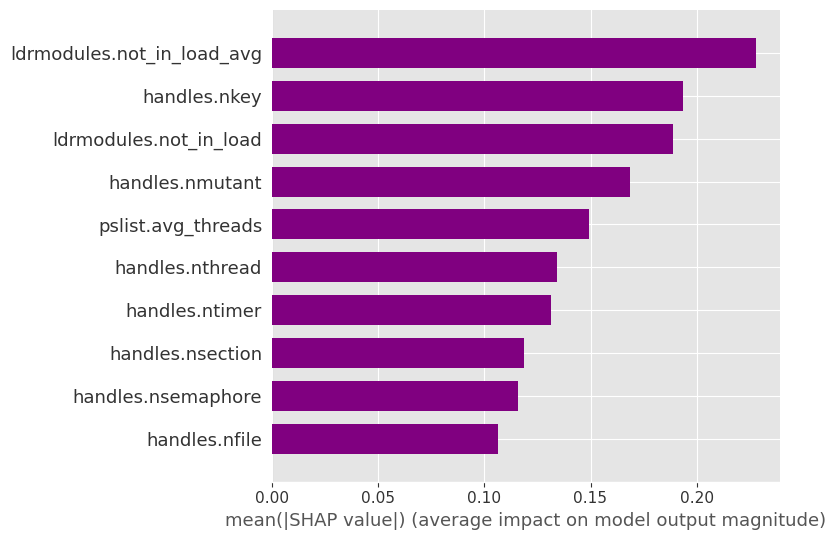

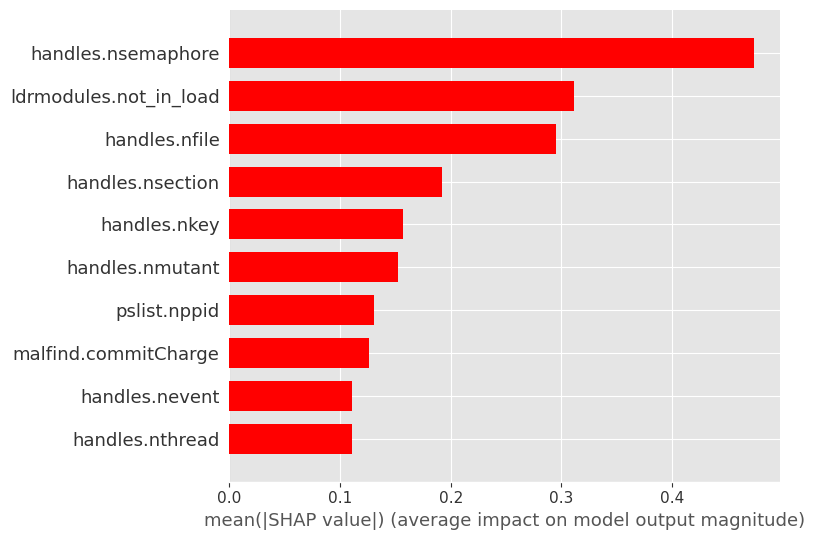

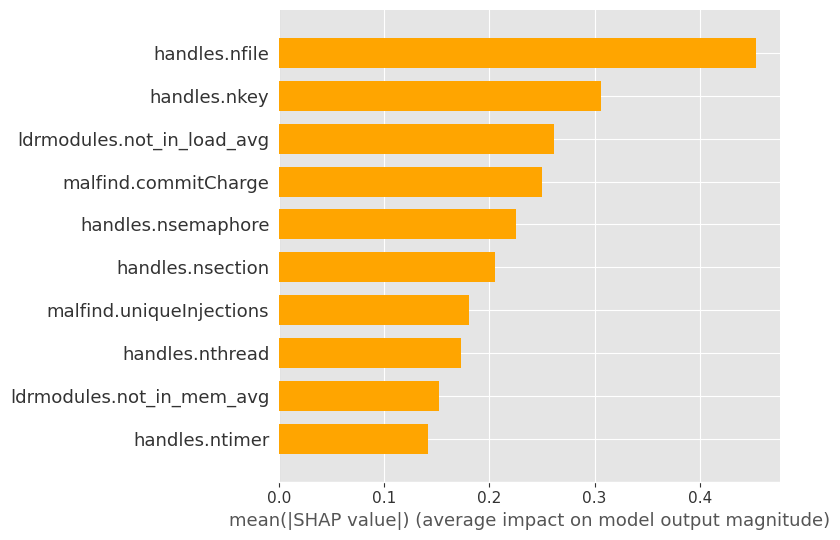

In [215]:
shap.summary_plot(
    shap_values2[:, :, 0],
    plot_type="bar", max_display= 10, color="purple"
)
shap.summary_plot(
    shap_values2[:, :, 1],
    plot_type="bar", max_display= 10, color= "red"
)
shap.summary_plot(
    shap_values2[:, :, 2],
    plot_type="bar", max_display= 10, color= "orange"
)


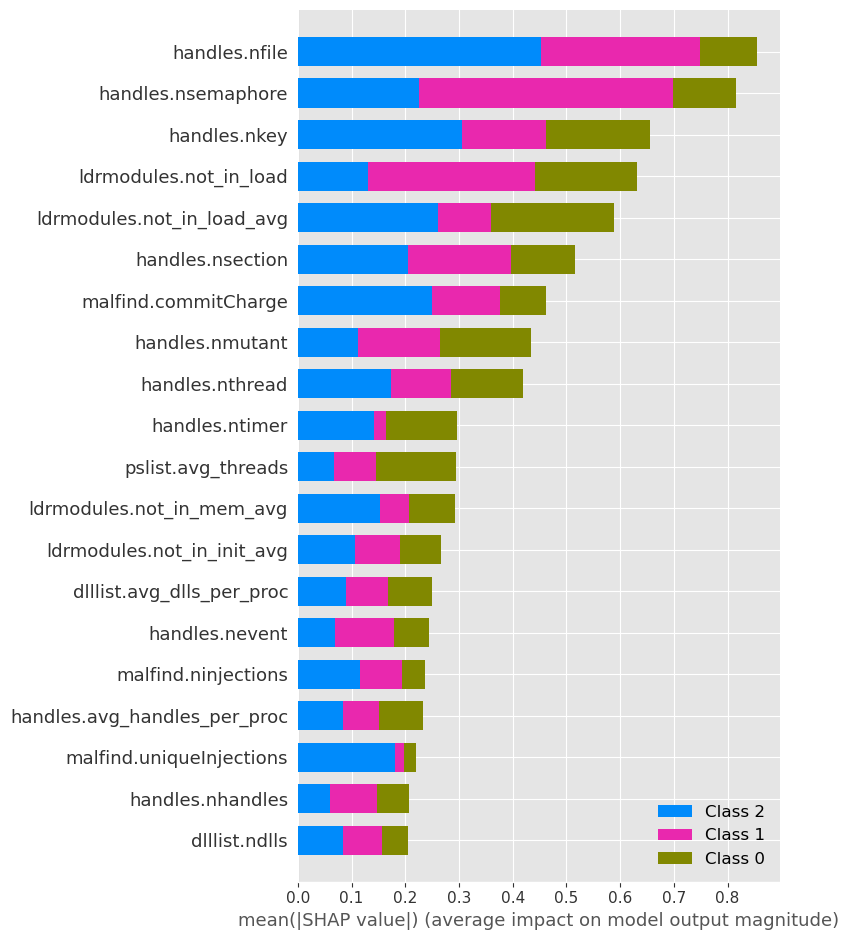

In [213]:
shap.summary_plot(
    [shap_values2[:, :, class_ind].values for class_ind in range(shap_values2.shape[-1])],
    feature_names=X2.columns,
    plot_type="bar", max_display=10
)

In [548]:
ShapRansomware=shap_values1[:, :, 1].values
ShapRansomware =np.array(ShapRansomware)
ShapRansomware = pd.DataFrame(ShapRansomware, columns= X1.columns)
ShapRansomware["Class"]=dataset.Class
ShapRansomware["Category"]=dataset.Category
ShapRansomware["Family"]=dataset.Family
#ShapRansomware=ShapRansomware[ShapRansomware.Category=="Ransomware"]

In [577]:
ShapSpyware=shap_values1[:, :, 2].values
ShapSpyware =np.array(ShapSpyware)
ShapSpyware = pd.DataFrame(ShapSpyware, columns= X1.columns)
ShapSpyware["Class"]=dataset.Class
ShapSpyware["Category"]=dataset.Category
ShapSpyware["Family"]=dataset.Family
#ShapBenign=ShapBenign[ShapBenign.Category=="Benign"]

In [ ]:
ShapBenign=shap_values1[:, :, 0].values
ShapBenign =np.array(ShapBenign)
ShapBenign = pd.DataFrame(ShapBenign, columns= X1.columns)
ShapBenign["Class"]=dataset.Class
ShapBenign["Category"]=dataset.Category
ShapBenign["Family"]=dataset.Family

In [567]:
ShapSpyware

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0          0.324270      0.072518             0.587945       0.002387   
1         -0.090265      0.597259             0.339699      -0.387895   
2          0.004596     -0.156534            -0.695469      -0.382922   
3         -0.095770     -0.174602             0.118077       0.620356   
4          0.006363     -0.019710            -0.541406      -0.435211   
...             ...           ...                  ...            ...   
58591     -0.280353     -0.176004             0.188072      -0.344410   
58592     -0.068568     -0.218374             0.428950      -0.062722   
58593     -0.059576     -0.126194             0.479129       0.343375   
58594     -0.051944     -0.111599             0.460518      -0.094779   
58595      0.061341     -0.027208             0.511940       0.281035   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                        0.190759             0.043645             -0.557448   
1                       -0.603834            -0.584519              0.368434   
2                       -0.228518            -0.083275             -0.474475   
3                       -0.073129             0.073942              0.135237   
4                       -0.165511            -0.443657              0.434120   
...                           ...                  ...                   ...   
58591                   -0.503014             0.042076              0.098775   
58592                   -0.123692             0.049891              0.142099   
58593                    0.009585             0.022353              0.122209   
58594                   -0.217546             0.058506              0.130766   
58595                    0.023908             0.081403              0.180942   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                  -0.034580                     -0.000590          0.001141   
1                  -0.021661                     -0.000025          0.000501   
2                  -0.087629                     -0.000177         -0.016451   
3                  -0.061780                      0.000007          0.001800   
4                  -0.004391                     -0.000279         -0.000417   
...                      ...                           ...               ...   
58591              -0.014539                     -0.000254          0.001490   
58592              -0.028195                      0.000004          0.001015   
58593              -0.085374                     -0.000091          0.001714   
58594               0.000241                      0.000002          0.001658   
58595              -0.053331                     -0.000588          0.001279   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0               0.898739             -0.230516                   0.0   
1              -0.497159             -0.887771                   0.0   
2              -1.008313              0.356867                   0.0   
3              -1.420257              0.295661                   0.0   
4              -0.571718             -0.664597                   0.0   
...                  ...                   ...                   ...   
58591           0.957064             -0.125085                   0.0   
58592           0.837496              0.301556                   0.0   
58593           1.026292              0.165476                   0.0   
58594           1.027423             -0.182000                   0.0   
58595           1.115703             -0.106897                   0.0   

       callbacks.ngeneric    Class    Category  Family  
0                     0.0   Benign      Benign  Benign  
1                     0.0   Benign      Benign  Benign  
2                     0.0   Benign      Benign  Benign  
3                     0.0   Benign      Benign  Benign  
4                     0.0   Benign      Benign  Benign  
.

In [568]:
SHAPDFTESTE=ShapSpyware.drop(["Class", "Category", "Family"], axis=1)
SHAPDFTESTE= ScalerShap1.fit_transform(SHAPDFTESTE)
SHAP2DTESTE=pcaShap1.fit_transform(SHAPDFTESTE)

SHAP2DTESTE = np.array(SHAP2DTESTE)
SHAPDFTESTE= pd.DataFrame(SHAP2DTESTE, columns=["Principal Component 1", "Principal Component 2"])

SHAPDFTESTE["Class"]=ShapSpyware.Class
SHAPDFTESTE["Category"]=ShapSpyware.Category
SHAPDFTESTE["Family"]=ShapSpyware.Family


print(pcaShap1.explained_variance_ratio_*100)
SHAPDFTESTE

[30.97098988 15.18198495]


Principal Component 1  Principal Component 2    Class    Category  \
0                   1.172925              -0.682626   Benign      Benign   
1                   0.253922               4.665094   Benign      Benign   
2                  -2.560760               0.251644   Benign      Benign   
3                  -0.155985              -0.456036   Benign      Benign   
4                  -0.708645               2.334234   Benign      Benign   
...                      ...                    ...      ...         ...   
58591              -0.483012               1.855123  Malware  Ransomware   
58592               0.140275               0.009838  Malware  Ransomware   
58593               0.919381               0.078110  Malware  Ransomware   
58594               0.702658               0.754011  Malware  Ransomware   
58595               1.549270              -0.032621  Malware  Ransomware   

       Family  
0      Benign  
1      Benign  
2      Benign  
3      Benign  
4      Benign  
...       ...  
58591   Shade  
58592   Shade  
58593   Shade  
58594   Shade  
58595   Shade  

[58596 rows x 5 columns]

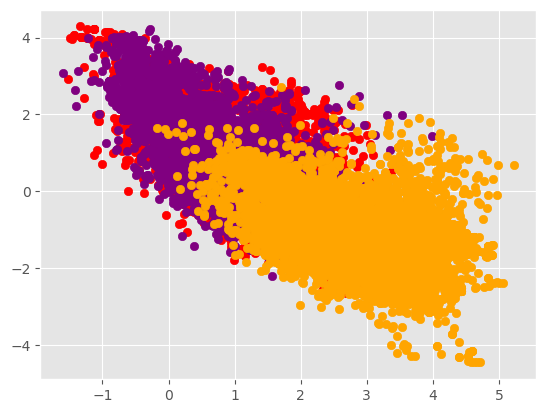

In [573]:
#plt.scatter(SHAPDFTESTE[SHAPDFTESTE.Category=="Benign"]["Principal Component 1"],SHAPDFTESTE[SHAPDFTESTE.Category=="Benign"]["Principal Component 2"], color= "green", label= "Benign")
plt.scatter(SHAPDFTESTE[SHAPDFTESTE.Category=="Ransomware"]["Principal Component 1"],SHAPDFTESTE[SHAPDFTESTE.Category=="Ransomware"]["Principal Component 2"], color="red", label= "Ransomware")
plt.scatter(SHAPDFTESTE[SHAPDFTESTE.Category=="Trojan"]["Principal Component 1"],SHAPDFTESTE[SHAPDFTESTE.Category=="Trojan"]["Principal Component 2"], color= "purple", label= "Trojan")
plt.scatter(SHAPDFTESTE[SHAPDFTESTE.Category=="Spyware"]["Principal Component 1"],SHAPDFTESTE[SHAPDFTESTE.Category=="Spyware"]["Principal Component 2"], color= "orange", label= "Spyware")

In [574]:
from sklearn.manifold import TSNE

In [575]:
tsne=TSNE(n_components=2, perplexity= 4)


In [578]:
SHAPDFTESTE=ShapSpyware.drop(["Class", "Category", "Family"], axis=1)
SHAPDFTESTE= ScalerShap1.fit_transform(SHAPDFTESTE)
SHAP2DTESTE=tsne.fit_transform(SHAPDFTESTE)

#SHAP2DTESTE = np.array(SHAP2DTESTE)
#SHAPDFTESTE= pd.DataFrame(SHAP2DTESTE, columns=["Principal Component 1", "Principal Component 2"])

#SHAPDFTESTE["Class"]=ShapSpyware.Class
#SHAPDFTESTE["Category"]=ShapSpyware.Category
#SHAPDFTESTE["Family"]=ShapSpyware.Family


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


In [581]:
SHAP2DTESTE.shape

(58596, 2)

In [582]:
SHAP2DTESTE = np.array(SHAP2DTESTE)
SHAPDFTESTE= pd.DataFrame(SHAP2DTESTE, columns=["Principal Component 1", "Principal Component 2"])
SHAPDFTESTE["Class"]=ShapSpyware.Class
SHAPDFTESTE["Category"]=ShapSpyware.Category
SHAPDFTESTE["Family"]=ShapSpyware.Family

SHAPDFTESTE

Principal Component 1  Principal Component 2    Class    Category  \
0                  44.338947              35.041859   Benign      Benign   
1                  74.218979             -29.624474   Benign      Benign   
2                 -52.709648              64.834030   Benign      Benign   
3                  58.678638              27.098377   Benign      Benign   
4                 -32.176502              28.394173   Benign      Benign   
...                      ...                    ...      ...         ...   
58591             -39.555744             -41.641987  Malware  Ransomware   
58592              19.727264              40.832916  Malware  Ransomware   
58593              26.331419              36.663174  Malware  Ransomware   
58594             -26.098814             -39.890995  Malware  Ransomware   
58595             -14.320285               0.175837  Malware  Ransomware   

       Family  
0      Benign  
1      Benign  
2      Benign  
3      Benign  
4      Benign  
...       ...  
58591   Shade  
58592   Shade  
58593   Shade  
58594   Shade  
58595   Shade  

[58596 rows x 5 columns]

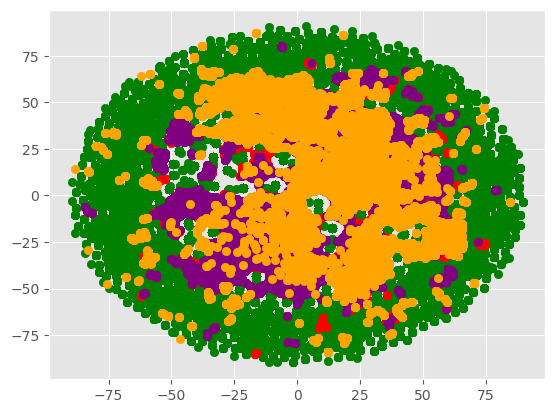

In [588]:
plt.scatter(SHAPDFTESTE[SHAPDFTESTE.Category=="Benign"]["Principal Component 1"],SHAPDFTESTE[SHAPDFTESTE.Category=="Benign"]["Principal Component 2"], color= "green", label= "Benign")
plt.scatter(SHAPDFTESTE[SHAPDFTESTE.Category=="Ransomware"]["Principal Component 1"],SHAPDFTESTE[SHAPDFTESTE.Category=="Ransomware"]["Principal Component 2"], color="red", label= "Ransomware")
plt.scatter(SHAPDFTESTE[SHAPDFTESTE.Category=="Trojan"]["Principal Component 1"],SHAPDFTESTE[SHAPDFTESTE.Category=="Trojan"]["Principal Component 2"], color= "purple", label= "Trojan")
plt.scatter(SHAPDFTESTE[SHAPDFTESTE.Category=="Spyware"]["Principal Component 1"],SHAPDFTESTE[SHAPDFTESTE.Category=="Spyware"]["Principal Component 2"], color= "orange", label= "Spyware")

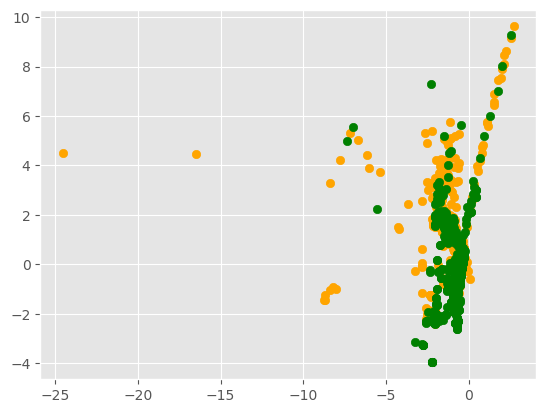

In [626]:
#plt.scatter(dataset2D[dataset2D.Family=="Shade"]["Principal Component 1"],dataset2D[dataset2D.Family=="Shade"]["Principal Component 2"], color="red", label= "Shade")
plt.scatter(dataset2D[dataset2D.Family=="Ako"]["Principal Component 1"],dataset2D[dataset2D.Family=="Ako"]["Principal Component 2"], color="orange", label= "Ako")
plt.scatter(dataset2D[dataset2D.Family=="Maze"]["Principal Component 1"],dataset2D[dataset2D.Family=="Maze"]["Principal Component 2"], color="green", label= "Maze")
#plt.scatter(dataset2D[dataset2D.Family=="Conti"]["Principal Component 1"],dataset2D[dataset2D.Family=="Conti"]["Principal Component 2"], color="blue", label= "Conti")

In [590]:
SHAPDFTESTE[SHAPDFTESTE.Category=="Ransomware"].Family.unique()

array(['Ako', 'Conti', 'Maze', 'Pysa', 'Shade'], dtype=object)

In [636]:
from umap import UMAP
import umap
import umap.plot

In [627]:
dataTeste= dataset.copy()

In [628]:
dataTeste.drop(corr_features, axis=1, inplace= True)

In [633]:
dataTeste
XXX= dataTeste.drop(["Category", "Class", "Family" ], axis= 1)

In [683]:
raw = umap.UMAP(
  n_components=2, n_neighbors=200).fit(XXX)

<AxesSubplot:>

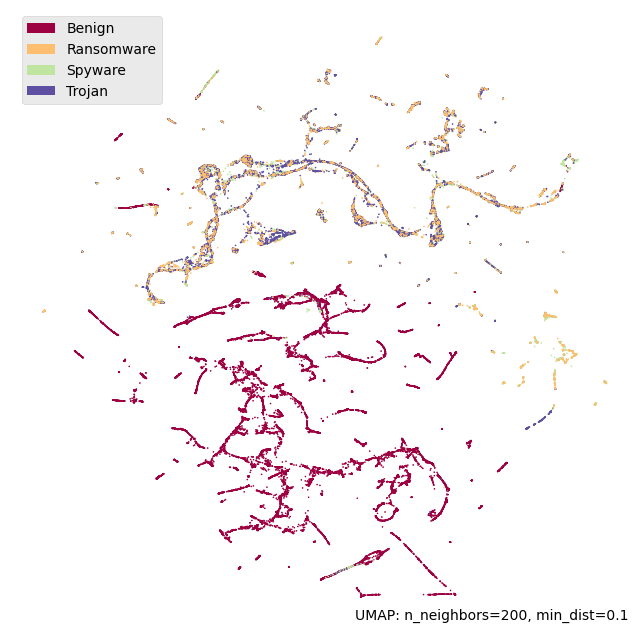

In [684]:
umap.plot.points(raw,labels=dataTeste.Category)

<AxesSubplot:>

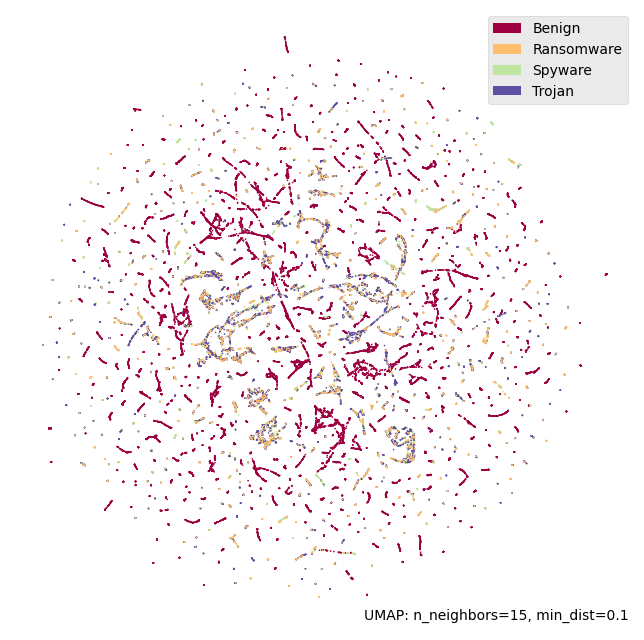

In [639]:
umap.plot.points(raw,labels=dataTeste.Category)

In [ ]:
shap_values

In [685]:
shap = umap.UMAP(
  n_components=2, n_neighbors=200).fit(shap_values.values)

<AxesSubplot:>

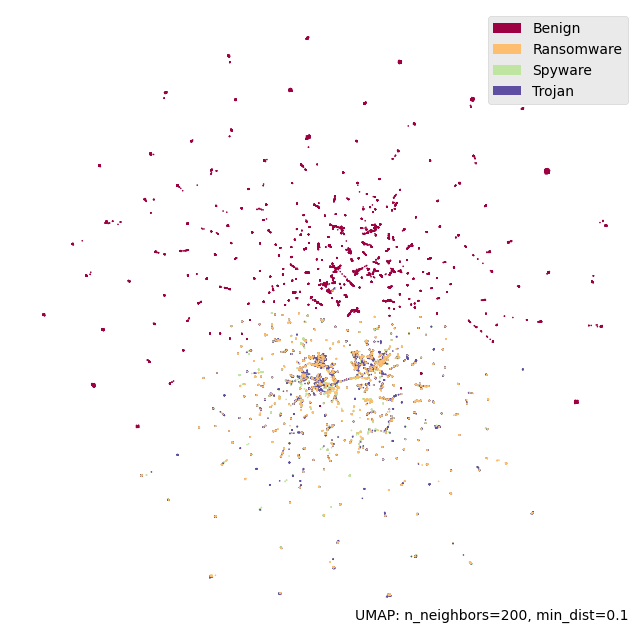

In [686]:
umap.plot.points(shap,labels=dataTeste.Category)

<AxesSubplot:>

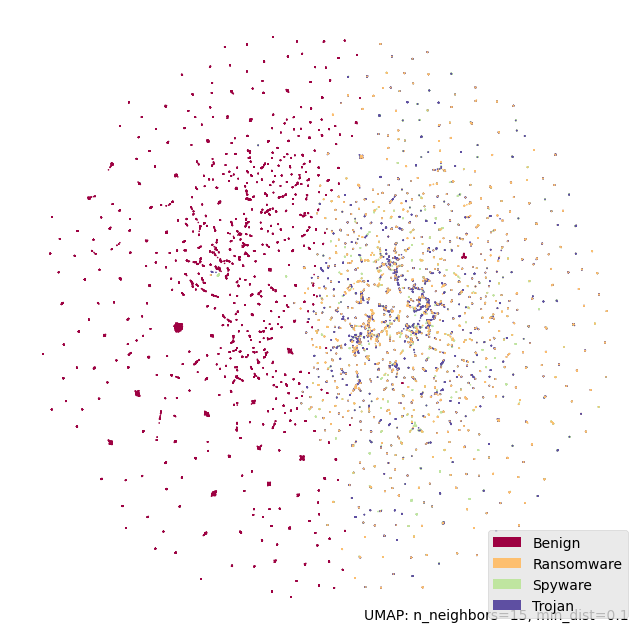

In [641]:
umap.plot.points(shap,labels=dataTeste.Category)

In [681]:
shaps = umap.UMAP(
  n_components=2, n_neighbors=200).fit_transform(shap_values.values)



KeyboardInterrupt: 

In [653]:
rawdf = umap.UMAP(
  n_components=2, n_neighbors=200).fit_transform(XXX)

Graph is not fully connected, spectral embedding may not work as expected.
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!


In [ ]:
umap.UMAP()

In [647]:
dataTeste

Category  pslist.nproc  pslist.nppid  pslist.avg_handlers  \
0          Benign            45            17           202.844444   
1          Benign            47            19           242.234043   
2          Benign            40            14           288.225000   
3          Benign            32            13           264.281250   
4          Benign            42            16           281.333333   
...           ...           ...           ...                  ...   
58591  Ransomware            37            15           215.486487   
58592  Ransomware            37            14           190.216216   
58593  Ransomware            38            15           210.026316   
58594  Ransomware            37            15           215.513513   
58595  Ransomware            38            15           213.026316   

       dlllist.ndlls  ldrmodules.not_in_load_avg  malfind.ninjections  \
0               1694                    0.030372                    5   
1               2074                    0.036167                   12   
2               1932                    0.026114                    5   
3               1445                    0.021483                    2   
4               2067                    0.047820                   12   
...              ...                         ...                  ...   
58591           1453                    0.029292                    3   
58592           1347                    0.030958                    3   
58593           1448                    0.029292                    3   
58594           1452                    0.029392                    3   
58595           1487                    0.029255                    3   

       malfind.commitCharge  psxview.not_in_pslist  \
0                        21                      2   
1                        77                      0   
2                         6                      0   
3                         2                      0   
4                        77                      4   
...                     ...                    ...   
58591                     3                      1   
58592                     3                      0   
58593                     3                      2   
58594                     3                      0   
58595                     3                      3   

       psxview.not_in_eprocess_pool  modules.nmodules  svcscan.nservices  \
0                                 0               138                389   
1                                 0               138                392   
2                                 0               137                395   
3                                 0               138                395   
4                                 0               138                392   
...                             ...               ...                ...   
58591                             0               138                389   
58592                             0               138                389   
58593                             0               138                389   
58594                             0               138                389   
58595                             0               138                389   

       callbacks.ncallbacks  callbacks.nanonymous  callbacks.ngeneric  \
0                        87                     0                   8   
1                        87                     0                   8   
2                        88                     0                   8   
3                        88                     0                   8   
4                        87                     0                   8   
...                     ...                   ...                 ...   
58591                    86                     0                   8   
58592                    88                     0                   8   
58593                    88                     0                   8   

In [ ]:
shapsDF= pd.DataFrame(shaps, columns=["x", "y"])
shapsDF["Category"]= dataTeste.Category
shapsDF["Class"]= dataTeste.Class

In [ ]:
#plt.scatter(shapsDF[shapsDF.Category=="Ransomware"]["x"], shapsDF[shapsDF.Category=="Ransomware"]["y"], color= "red", label= "Ransomware")
#plt.scatter(shapsDF[shapsDF.Category=="Trojan"]["x"], shapsDF[shapsDF.Category=="Trojan"]["y"], color= "orange", label= "Trojan")
#plt.scatter(shapsDF[shapsDF.Category=="Spyware"]["x"], shapsDF[shapsDF.Category=="Spyware"]["y"], color= "blue", label= "Spyware")
plt.scatter(shapsDF[shapsDF.Class=="Malware"]["x"], shapsDF[shapsDF.Class=="Malware"]["y"], color= "red", label= "Malware")
plt.scatter(shapsDF[shapsDF.Class=="Benign"]["x"], shapsDF[shapsDF.Class=="Benign"]["y"], color= "green", label= "Benign")
plt.title("Shap values data")
plt.legend()

In [662]:
ShapsDFClusterTeste=kmeansShap.fit_predict(shapsDF[["x", "y"]])
shapsDF["Cluster"]=ShapCluster2pred
shapsDF

x          y    Category    Class  Cluster
0       8.464370   2.857452      Benign   Benign        0
1      -1.177091   6.744193      Benign   Benign        1
2       1.658411  -7.135809      Benign   Benign        1
3      -3.479182   5.106184      Benign   Benign        1
4       0.778795  18.190702      Benign   Benign        1
...          ...        ...         ...      ...      ...
58591  14.813461  -7.714716  Ransomware  Malware        0
58592   7.086864  -0.793828  Ransomware  Malware        0
58593  11.106484  -7.675910  Ransomware  Malware        0
58594  11.129095  12.572514  Ransomware  Malware        0
58595  13.370403  -9.222223  Ransomware  Malware        0

[58596 rows x 5 columns]

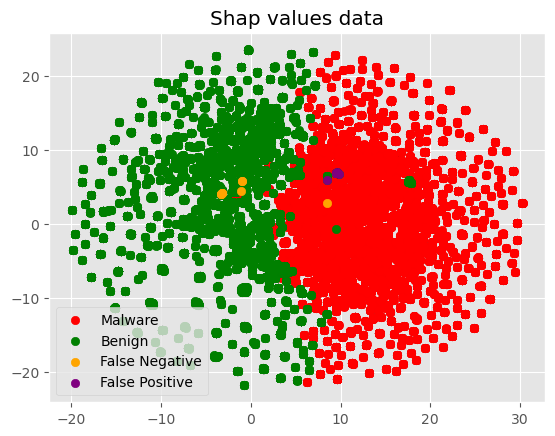

In [667]:
plt.scatter(shapsDF[shapsDF.Cluster==0]["x"],shapsDF[shapsDF.Cluster==0]["y"], color="red", label="Malware")
plt.scatter(shapsDF[shapsDF.Cluster==1]["x"],shapsDF[shapsDF.Cluster==1]["y"], color="green", label="Benign")
plt.scatter(shapsDF[(shapsDF.Cluster==0) & (shapsDF.Class== "Benign")]["x"],shapsDF[(shapsDF.Cluster==0) & (SHAPDF.Class== "Benign")]["y"], color= "orange", label ="False Negative")
plt.scatter(shapsDF[(shapsDF.Cluster==1) & (shapsDF.Class== "Malware")]["x"],shapsDF[(shapsDF.Cluster==1) & (SHAPDF.Class== "Malware")]["y"], color= "purple", label ="False Positive")
plt.title("Shap values data")
plt.legend()

In [679]:
accuracy0Malware(shapsDF)

Accuracy: 99.94026896033859 % 
 False Positive rate: 0.08533005665915763 %


Boolean Series key will be reindexed to match DataFrame index.


In [657]:
rawDF= pd.DataFrame(rawdf, columns=["x", "y"])
rawDF["Category"]= dataTeste.Category
rawDF["Class"]= dataTeste.Class

In [670]:
rawDFpred=kmeans2.fit_predict(rawDF[["x", "y"]])
rawDF["Cluster"]= rawDFpred


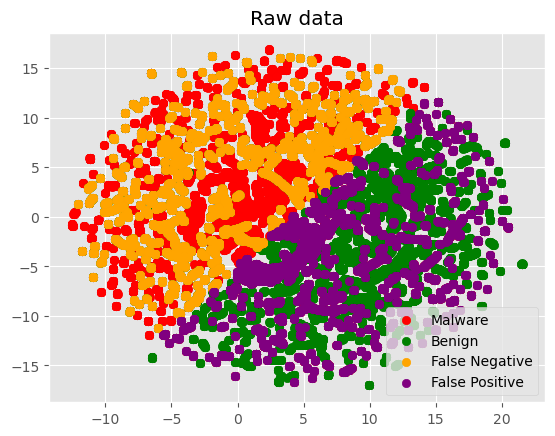

In [673]:
plt.scatter(rawDF[shapsDF.Cluster==0]["x"],rawDF[shapsDF.Cluster==0]["y"], color="red", label="Malware")
plt.scatter(rawDF[shapsDF.Cluster==1]["x"],rawDF[shapsDF.Cluster==1]["y"], color="green", label="Benign")
plt.scatter(rawDF[(rawDF.Cluster==0) & (rawDF.Class== "Benign")]["x"],rawDF[(rawDF.Cluster==0) & (rawDF.Class== "Benign")]["y"], color= "orange", label ="False Negative")
plt.scatter(rawDF[(rawDF.Cluster==1) & (rawDF.Class== "Malware")]["x"],rawDF[(rawDF.Cluster==1) & (rawDF.Class== "Malware")]["y"], color= "purple", label ="False Positive")
plt.title("Raw data")
plt.legend()

In [680]:
accuracy0Malware(rawDF)

Accuracy: 51.65198989692129 % 
 False Positive rate: 48.39238173254147 %


Boolean Series key will be reindexed to match DataFrame index.


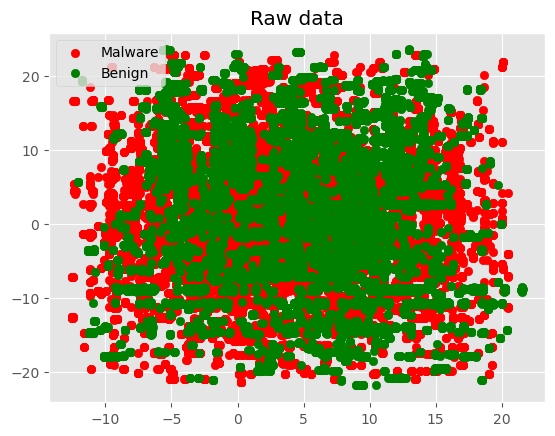

In [658]:
plt.scatter(rawDF[rawDF.Class=="Malware"]["x"], shapsDF[rawDF.Class=="Malware"]["y"], color= "red", label="Malware")
plt.scatter(rawDF[rawDF.Class=="Benign"]["x"], shapsDF[rawDF.Class=="Benign"]["y"], color= "green", label= "Benign")
plt.title("Raw data")
plt.legend()

In [692]:
shap_values.values

array([[-0.41271061,  0.40727972,  3.14309978, ..., -0.46967066,
         0.        ,  0.        ],
       [-0.64754109,  1.20473427, -0.60574669, ..., -1.13263848,
         0.        ,  0.        ],
       [-0.10310462, -0.42743578, -2.39403788, ..., -0.46143733,
         0.        ,  0.        ],
       ...,
       [ 0.81495232,  0.70962456,  2.35841769, ..., -0.025617  ,
         0.        ,  0.        ],
       [ 0.64931902,  0.61597515,  1.90510854, ..., -0.08887275,
         0.        ,  0.        ],
       [ 0.57349944,  0.68622535,  2.24810833, ...,  0.98880697,
         0.        ,  0.        ]])

In [691]:
shapsDF

x          y    Category    Class  Cluster
0       8.464370   2.857452      Benign   Benign        0
1      -1.177091   6.744193      Benign   Benign        1
2       1.658411  -7.135809      Benign   Benign        1
3      -3.479182   5.106184      Benign   Benign        1
4       0.778795  18.190702      Benign   Benign        1
...          ...        ...         ...      ...      ...
58591  14.813461  -7.714716  Ransomware  Malware        0
58592   7.086864  -0.793828  Ransomware  Malware        0
58593  11.106484  -7.675910  Ransomware  Malware        0
58594  11.129095  12.572514  Ransomware  Malware        0
58595  13.370403  -9.222223  Ransomware  Malware        0

[58596 rows x 5 columns]

In [690]:
shapsDF.to_csv("C:\\Users\\rodri\\OneDrive\\Desktop\\tese\\Data\\shapsDF.csv",sep=",")